In [1]:
#!pip install lightgbm
#!pip install catboost
#!pip install scikit-learn --upgrade
#!pip install sktime --user
#!pip install shap --user

#print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [2]:
#LOADS LIBRARIES
import os
import sys
import warnings
warnings.simplefilter('ignore')
import pickle
#import dill as pickle

import numpy as np
import pandas as pd
import math

import time 
import datetime
from dateutil.relativedelta import relativedelta

In [3]:
import sklearn

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, KBinsDiscretizer
#import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [4]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import uniform
from random import randint
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,\
                            precision_recall_curve, roc_auc_score, balanced_accuracy_score, log_loss

from sklearn.model_selection import cross_val_score, learning_curve, validation_curve,\
                                    TimeSeriesSplit, RandomizedSearchCV, GridSearchCV, StratifiedKFold,\
                                    train_test_split, KFold, cross_validate

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interactive, interact, fixed
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()

import plotly.graph_objs as go
import shap
import itertools 

In [7]:
DIR_OUTPUTS = r'C:\Users\willi\Documents\EJERCICIOS\TRADING\outputs/'

# Develops analitycal model simulation

In [8]:
df_analysis = pd.read_pickle(DIR_OUTPUTS + 'df_spx500_5m_s1.pkl')

print(df_analysis.shape)
print('\n')
print(min(df_analysis['Datetime']))
print(max(df_analysis['Datetime']))

(466, 54)


2022-02-08 12:30:00
2022-03-07 11:33:43


In [9]:

def simulation(order_datetime, start_datetime, end_datetime):
    
    ################################################################################################
    #Gets the simulation data
    df_analysis_01a = df_analysis[(df_analysis['Datetime']>=start_datetime)
                                 &(df_analysis['Datetime']<=end_datetime)]

    df_analysis_01a = df_analysis_01a.reset_index(drop=True)

    df_analysis_01 = df_analysis_01a.copy()
    ################################################################################################



    ################################################################################################
    # Defines variables
    # Here all cateorical columns
    ls_cat_variables = [
                     ]

    # Here all numerical columns

    ls_ss1pcavars = ['ss1_close_c1','ss1_close_c2','ss1_close_c3']
    ls_ss1vars2 = ['ss1_close_' + str(x) for x in range(8,0,-1) ]
    ls_slopevars = ['slope_close_' + str(x) for x in range(0,4) ]

    ls_ss1_macdh = ['ss1_macdh_c1','ss1_macdh_c2','ss1_macdh_c3']
    ls_ss1_macdh2 = ['ss1_macdh_' + str(x) for x in range(8,0,-1) ]
    ls_slopes_macdh = ['slope_macdh_' + str(x) for x in range(0,4) ]

    ls_ss1_vols = ['ss1_vols_c1','ss1_vols_c2','ss1_vols_c3']
    ls_ss1_vols2 = ['ss1_vols_' + str(x) for x in range(8,0,-1) ]
    ls_slopes_vols = ['slope_vols_' + str(x) for x in range(0,4) ]

    ls_num_variables = ls_slopevars + ls_ss1vars2 + ls_ss1pcavars +\
                        ls_slopes_vols + ls_ss1_vols2 + ls_ss1_vols + \
                        ls_slopes_macdh + ls_ss1_macdh2 + ls_ss1_macdh
                        # ls_slopes_macd + ls_ss80_macd2 + ls_ss80_macd + \

    # Here all key columnsdf_analysis
    ls_keys = [
        'Datetime',
    ]

    Target = 'target_order_bin' #specify the column containing the target
    Target_desc = 'target_order'

    df_analysis_01[ls_num_variables] = df_analysis_01[ls_num_variables].astype(float)
    ################################################################################################



    ################################################################################################
    #Codes the target to better understanding for the model

    df_target_coded =  df_analysis_01[Target_desc].value_counts(dropna=False).reset_index()
    df_target_coded =  df_target_coded.sort_values(['index']).reset_index(drop=True)
    df_target_coded = df_target_coded.reset_index()
    df_target_coded['level_0'] = df_target_coded['level_0'].apply(lambda x: str(x).zfill(2))


    df_target_coded = df_target_coded.rename(columns={Target_desc:'Frequency',
                                                'level_0':Target_desc + '_coded',
                                                'index':Target_desc})

    df_analysis_02a = pd.merge(df_analysis_01,
                             df_target_coded[[Target_desc, Target_desc + '_coded']],
                             on = [Target_desc],
                             how='left').copy()


    # SAVING POINT
    df_target_coded.to_pickle(DIR_OUTPUTS + 'df_periodo_cancelacion_coded' + '.pkl')
    ################################################################################################



    #############################################################################################################################
    #Filters the data to a sales model
    df_analysis_02 = df_analysis_02a[(df_analysis_02a['target_order'].isin(['NULL'])==False)].copy()

    #Filters the data to a TRAIN test
    df_analysis_train_01 = df_analysis_02a[(df_analysis_02a['Datetime'] < order_datetime)
                                          &(df_analysis_02a['target_order'].isin(['NULL'])==False)].copy()

    #Filters the data to a TEST test
    df_analysis_test_01 = df_analysis_02a[(df_analysis_02a['Datetime'] >= order_datetime)].copy()
    #############################################################################################################################



    #############################################################################################################################
    #Defines X vector to all process

    X_train = df_analysis_train_01[ls_cat_variables + ls_num_variables]

    y_train = df_analysis_train_01[Target_desc + '_coded']

    X_test = df_analysis_test_01[ls_cat_variables + ls_num_variables]

    y_test = df_analysis_test_01[Target_desc + '_coded']
    #############################################################################################################################


    #############################################################################################################################
    # Creating a Stratified Cross folds for temporal data

    n_test = 2
    gap = 7

    n_splits = round(len(X_train)/n_test) - 1
    print('Number of splits for CV: ',n_splits)

    skf = TimeSeriesSplit(n_splits=n_splits)
    #############################################################################################################################



    #############################################################################################################################
    # RF MODEL CALIBRATION

    # Defines the column transformer
    rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_num_variables),
                                            ]) 

    #Prepares model pip

    rf_pip = Pipeline([('preprocessing', rf_transformer),
                        ('model', RandomForestClassifier())])

    # grid of model hyperparameters to be optimised, you can look for parameters definitions in the model link
    rf_params = {'model__n_estimators': [100], #Number of trees
                  'model__criterion': ['gini'],
                  'model__max_depth': [7],
                  'model__class_weight':['balanced'],
                  'model__random_state': [0],
                 }


    # We launch a grid seach: testing different hyperparameters on a cross validation 
    # and select the ones that optimises the performance of the mode 

    rf_search = RandomizedSearchCV(rf_pip, rf_params, 
                                    n_iter=10, # This is the number of parameters to test , you can choose more
                                    n_jobs=-1, # Number of jobs /threads
                                    verbose=2, 
                                    cv=skf, # the stratified crossvalidation that we created before
                                    scoring='balanced_accuracy')

    def f_rf_search():
        rf_search.fit(X_train, y_train)

        print('Best parameters :', rf_search.best_params_)
        print('Best score (balanced accuracy) :', rf_search.best_score_)

        return rf_search
    #############################################################################################################################



    #############################################################################################################################
    # Hold Predictions table

    # Selectiong winner model in the calibration program
    selected_model = 'RF'

    X_work = X_test
    y_work = y_test

    ls_target_info = ['Datetime','Close','target_order','target_close','target_difference','target_date','target_date_diff']


    if selected_model == 'RF':
        winner_model = f_rf_search()
    if selected_model == 'EX':
        winner_model = f_ex_search()
    if selected_model == 'clf':
        winner_model = f_clf()
    if selected_model == 'lgbm':
        winner_model = f_lgbm_search()

    df_datainfo = df_analysis_02a.iloc[X_work.index,:]
    df_datainfo = df_datainfo[ls_target_info]
    df_datainfo = df_datainfo.reset_index(drop=True)

    #########################################################################
    y_prob = winner_model.predict_proba(X_work)

    df_model_probs = pd.DataFrame(y_prob)
    df_model_probs = df_model_probs.reset_index(drop=True)
    #########################################################################


    #########################################################################
    y_pred = winner_model.predict(X_work)

    df_model_preds = df_datainfo
    df_model_preds = df_model_preds.reset_index(drop=True)
    #########################################################################


    #######################################################################################################
    df_model_preds['target_order_coded'] = y_work.reset_index(drop=True)
    df_model_preds.loc[df_model_preds['target_order_coded'].isnull(),'target_order_coded']='NULL'

    df_model_preds['y_pred'] = y_pred

    dc_renamecols = {
        'target_order_coded': 'y_pred',
        'target_order': 'prediction_order',
        }

    df_prediction_coded = df_target_coded.rename(columns=dc_renamecols)


    df_model_preds = pd.merge(df_model_preds,
                          df_prediction_coded[['y_pred','prediction_order']],
                          on = ['y_pred'],
                          how='left'
                          ).copy()

    df_model_preds = pd.concat([df_model_preds,df_model_probs],axis=1)

    try:
        df_model_preds['max_prob'] = df_model_preds[[0,1,2,3]].max(axis=1)
    except:
        df_model_preds['max_prob'] = df_model_preds[[0,1,2]].max(axis=1)
    #######################################################################################################


    ##############################################################################################################################
    # Confusion Matrix

    ls_model_matches = []

    for i in range(1,len(df_model_preds)+1):
        #df_model_preds_01 = df_model_preds[df_model_preds['max_prob']>=0.42].copy()
        df_model_preds_01 = df_model_preds.iloc[:i,].copy()


        df_summary = df_model_preds_01.groupby(['target_order','prediction_order'] ).agg(
            orders_quantity = ('max_prob','count'),
            median_time = ('target_date_diff','median')
        )

        df_summary = df_summary.reset_index()

        True_buys = sum(df_summary[(df_summary['target_order'].isin(['BUY','BUY2']))&(df_summary['prediction_order'].isin(['BUY','BUY2']))]['orders_quantity'])
        True_sells = sum(df_summary[(df_summary['target_order'].isin(['SELL','SELL2']))&(df_summary['prediction_order'].isin(['SELL','SELL2']))]['orders_quantity'])
        Total_orders = sum(df_summary['orders_quantity'])

        pp_model_match = (True_buys + True_sells) / Total_orders
        ls_model_matches.append(pp_model_match)

    df_summary.sort_values(['orders_quantity'],ascending=[False])

    print(df_analysis_train_01.shape)
    print(min(df_analysis_train_01['Datetime']))
    print(max(df_analysis_train_01['Datetime']))

    print(df_model_preds.shape)
    print(min(df_model_preds['Datetime']))
    print(max(df_model_preds['Datetime']))

    print('% Model match: ', pp_model_match)

    plt.scatter(range(0,len(ls_model_matches)), ls_model_matches)
    plt.show()
    ##############################################################################################################################


    ##############################################################################################################################
    # Consolidates simulation results
    df_sim_results = df_model_preds.iloc[0:2,:]
    df_sim_results['Model match'] = pp_model_match
    #df_sim_results
    ##############################################################################################################################

    return df_sim_results

Number of splits for CV:  64
Fitting 64 folds for each of 1 candidates, totalling 64 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.546875
(130, 55)
2022-02-28 09:30:00
2022-03-04 15:45:00
(10, 15)
2022-03-07 09:30:00
2022-03-07 11:33:43
% Model match:  0.2


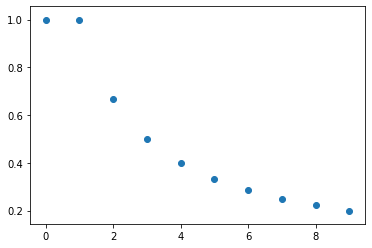

Datetime        Close target_order  target_close  \
0 2022-03-07 09:30:00  4295.250000         SELL   4274.589844   
1 2022-03-07 09:45:00  4285.310059         SELL   4261.279785   

   target_difference         target_date  target_date_diff target_order_coded  \
0              -21.0 2022-03-07 10:00:00              30.0                 03   
1              -24.0 2022-03-07 10:45:00              60.0                 03   

  y_pred prediction_order         0         1         2         3  max_prob  \
0     04            SELL2  0.266508  0.064877  0.093829  0.574786  0.574786   
1     04            SELL2  0.383050  0.084031  0.041746  0.491173  0.491173   

   Model match  
0          0.2  
1          0.2

In [10]:
#Defines the time window to do analisys
order_datetime = datetime.datetime(2022,3,7,9,30)
start_datetime = order_datetime - relativedelta(days=7)
end_datetime = order_datetime + relativedelta(days=1.5)

simulation(order_datetime, start_datetime, end_datetime)

In [16]:
ls_valdates = np.unique(np.array(df_analysis['date'].tolist())).tolist()
ls_valdates

ls_seldates = ls_valdates
ls_seldates = [x for x in ls_valdates if (x >= datetime.datetime(2022,2,16).date())]

ls_inits_dates = []
for dt in ls_seldates:
    dtt = datetime.datetime(dt.year,dt.month,dt.day,9,45)
    ls_inits_dates.append(dtt)

ls_inits_dates

[datetime.datetime(2022, 2, 16, 9, 45),
 datetime.datetime(2022, 2, 17, 9, 45),
 datetime.datetime(2022, 2, 18, 9, 45),
 datetime.datetime(2022, 2, 22, 9, 45),
 datetime.datetime(2022, 2, 23, 9, 45),
 datetime.datetime(2022, 2, 24, 9, 45),
 datetime.datetime(2022, 2, 25, 9, 45),
 datetime.datetime(2022, 2, 28, 9, 45),
 datetime.datetime(2022, 3, 1, 9, 45),
 datetime.datetime(2022, 3, 2, 9, 45),
 datetime.datetime(2022, 3, 3, 9, 45),
 datetime.datetime(2022, 3, 4, 9, 45),
 datetime.datetime(2022, 3, 7, 9, 45)]

In [17]:

#ls_inits_dates = [datetime.datetime(2022,2,4,9,45)]


for init_date in ls_inits_dates:
    j = init_date
    testing_dates = [init_date]

    for i in range(0,24):
        gen_date = init_date + relativedelta(minutes=15)
        testing_dates.append(gen_date)
        init_date = gen_date
        
    if j==ls_inits_dates[0]:
        testing_dates_01 = testing_dates
    else:
        testing_dates_01 = testing_dates_01 + testing_dates
    
testing_dates_01

[datetime.datetime(2022, 2, 16, 9, 45),
 datetime.datetime(2022, 2, 16, 10, 0),
 datetime.datetime(2022, 2, 16, 10, 15),
 datetime.datetime(2022, 2, 16, 10, 30),
 datetime.datetime(2022, 2, 16, 10, 45),
 datetime.datetime(2022, 2, 16, 11, 0),
 datetime.datetime(2022, 2, 16, 11, 15),
 datetime.datetime(2022, 2, 16, 11, 30),
 datetime.datetime(2022, 2, 16, 11, 45),
 datetime.datetime(2022, 2, 16, 12, 0),
 datetime.datetime(2022, 2, 16, 12, 15),
 datetime.datetime(2022, 2, 16, 12, 30),
 datetime.datetime(2022, 2, 16, 12, 45),
 datetime.datetime(2022, 2, 16, 13, 0),
 datetime.datetime(2022, 2, 16, 13, 15),
 datetime.datetime(2022, 2, 16, 13, 30),
 datetime.datetime(2022, 2, 16, 13, 45),
 datetime.datetime(2022, 2, 16, 14, 0),
 datetime.datetime(2022, 2, 16, 14, 15),
 datetime.datetime(2022, 2, 16, 14, 30),
 datetime.datetime(2022, 2, 16, 14, 45),
 datetime.datetime(2022, 2, 16, 15, 0),
 datetime.datetime(2022, 2, 16, 15, 15),
 datetime.datetime(2022, 2, 16, 15, 30),
 datetime.datetime(2022

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5490196078431373
(104, 55)
2022-02-10 09:45:00
2022-02-16 09:30:00
(51, 15)
2022-02-16 09:45:00
2022-02-17 15:45:00
% Model match:  0.6470588235294118


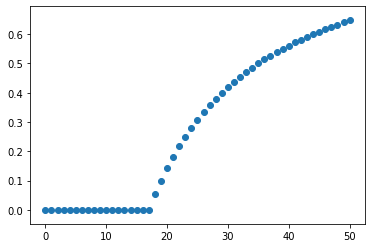

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(104, 55)
2022-02-10 10:00:00
2022-02-16 09:45:00
(50, 15)
2022-02-16 10:00:00
2022-02-17 15:45:00
% Model match:  0.68


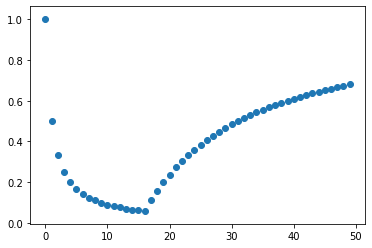

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5392156862745098
(104, 55)
2022-02-10 10:15:00
2022-02-16 10:00:00
(49, 15)
2022-02-16 10:15:00
2022-02-17 15:45:00
% Model match:  0.6938775510204082


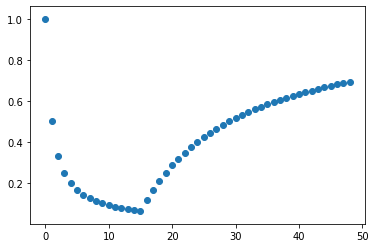

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(104, 55)
2022-02-10 10:30:00
2022-02-16 10:15:00
(48, 15)
2022-02-16 10:30:00
2022-02-17 15:45:00
% Model match:  0.7083333333333334


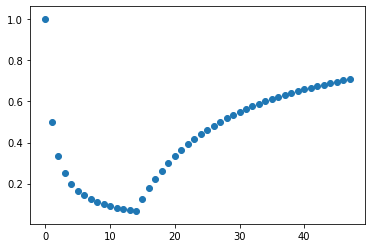

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5196078431372549
(104, 55)
2022-02-10 10:45:00
2022-02-16 10:30:00
(47, 15)
2022-02-16 10:45:00
2022-02-17 15:45:00
% Model match:  0.7446808510638298


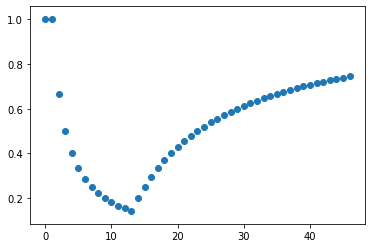

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5980392156862745
(104, 55)
2022-02-10 11:00:00
2022-02-16 10:45:00
(46, 15)
2022-02-16 11:00:00
2022-02-17 15:45:00
% Model match:  0.717391304347826


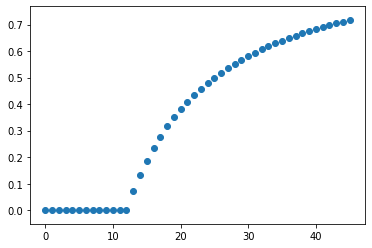

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5392156862745098
(104, 55)
2022-02-10 11:15:00
2022-02-16 11:00:00
(45, 15)
2022-02-16 11:15:00
2022-02-17 15:45:00
% Model match:  0.7555555555555555


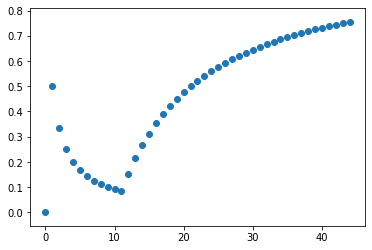

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(104, 55)
2022-02-10 11:30:00
2022-02-16 11:15:00
(44, 15)
2022-02-16 11:30:00
2022-02-17 15:45:00
% Model match:  0.7727272727272727


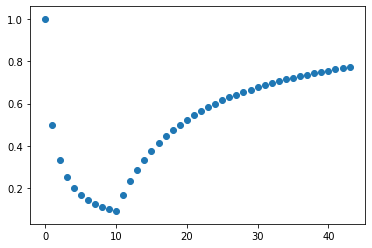

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5490196078431373
(104, 55)
2022-02-10 11:45:00
2022-02-16 11:30:00
(43, 15)
2022-02-16 11:45:00
2022-02-17 15:45:00
% Model match:  0.8372093023255814


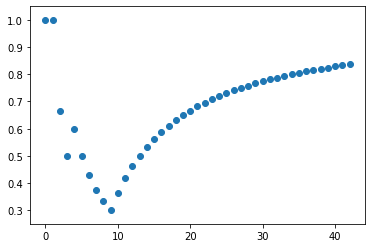

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(104, 55)
2022-02-10 12:00:00
2022-02-16 11:45:00
(42, 15)
2022-02-16 12:00:00
2022-02-17 15:45:00
% Model match:  0.8571428571428571


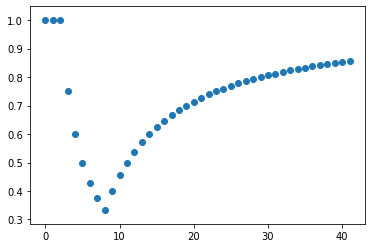

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5588235294117647
(104, 55)
2022-02-10 12:15:00
2022-02-16 12:00:00
(41, 15)
2022-02-16 12:15:00
2022-02-17 15:45:00
% Model match:  0.926829268292683


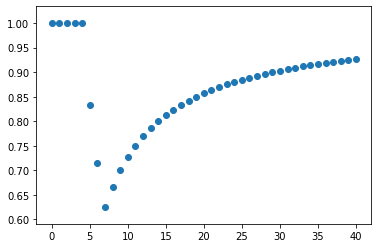

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(104, 55)
2022-02-10 12:30:00
2022-02-16 12:15:00
(40, 15)
2022-02-16 12:30:00
2022-02-17 15:45:00
% Model match:  0.925


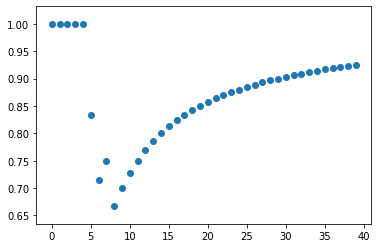

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5392156862745098
(104, 55)
2022-02-10 12:45:00
2022-02-16 12:30:00
(39, 15)
2022-02-16 12:45:00
2022-02-17 15:45:00
% Model match:  0.8974358974358975


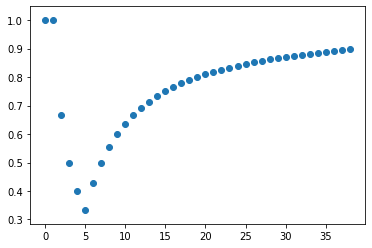

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(104, 55)
2022-02-10 13:00:00
2022-02-16 12:45:00
(38, 15)
2022-02-16 13:00:00
2022-02-17 15:45:00
% Model match:  0.9473684210526315


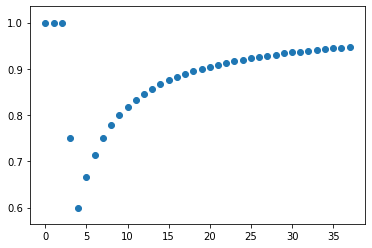

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5588235294117647
(104, 55)
2022-02-10 13:15:00
2022-02-16 13:00:00
(37, 15)
2022-02-16 13:15:00
2022-02-17 15:45:00
% Model match:  0.9459459459459459


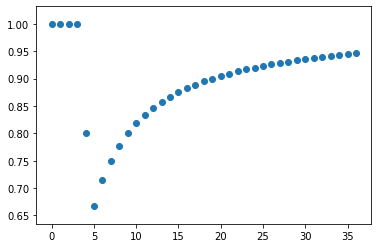

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(104, 55)
2022-02-10 13:30:00
2022-02-16 13:15:00
(36, 15)
2022-02-16 13:30:00
2022-02-17 15:45:00
% Model match:  0.9166666666666666


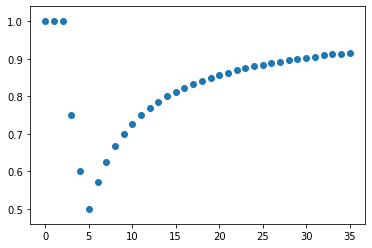

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5490196078431373
(104, 55)
2022-02-10 13:45:00
2022-02-16 13:30:00
(35, 15)
2022-02-16 13:45:00
2022-02-17 15:45:00
% Model match:  0.9714285714285714


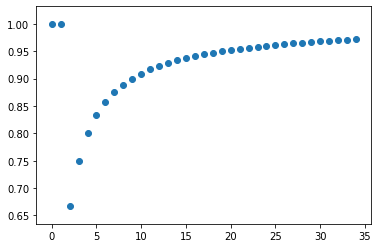

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6862745098039216
(104, 55)
2022-02-10 14:00:00
2022-02-16 13:45:00
(34, 15)
2022-02-16 14:00:00
2022-02-17 15:45:00
% Model match:  0.8823529411764706


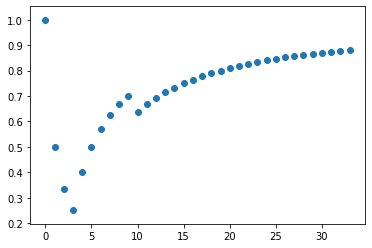

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5686274509803921
(104, 55)
2022-02-10 14:15:00
2022-02-16 14:00:00
(33, 15)
2022-02-16 14:15:00
2022-02-17 15:45:00
% Model match:  0.8484848484848485


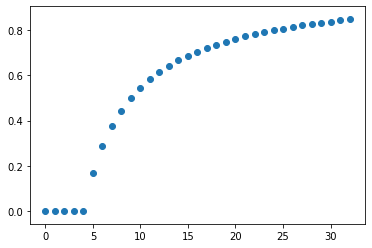

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(104, 55)
2022-02-10 14:30:00
2022-02-16 14:15:00
(32, 15)
2022-02-16 14:30:00
2022-02-17 15:45:00
% Model match:  1.0


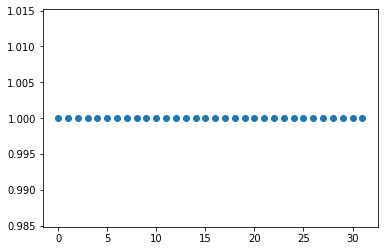

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5588235294117647
(104, 55)
2022-02-10 14:45:00
2022-02-16 14:30:00
(31, 15)
2022-02-16 14:45:00
2022-02-17 15:45:00
% Model match:  0.967741935483871


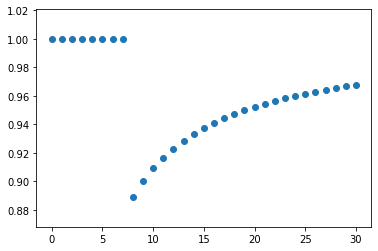

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(104, 55)
2022-02-10 15:00:00
2022-02-16 14:45:00
(30, 15)
2022-02-16 15:00:00
2022-02-17 15:45:00
% Model match:  0.8666666666666667


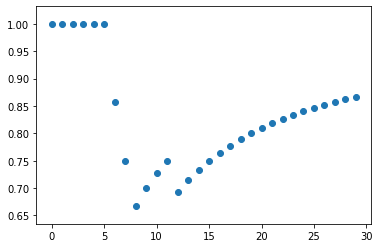

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5686274509803921
(104, 55)
2022-02-10 15:15:00
2022-02-16 15:00:00
(29, 15)
2022-02-16 15:15:00
2022-02-17 15:45:00
% Model match:  0.8275862068965517


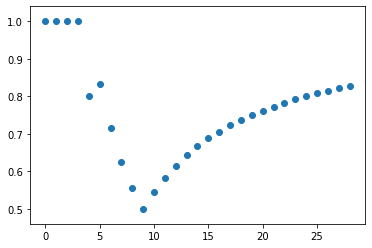

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6862745098039216
(104, 55)
2022-02-10 15:30:00
2022-02-16 15:15:00
(28, 15)
2022-02-16 15:30:00
2022-02-17 15:45:00
% Model match:  0.9285714285714286


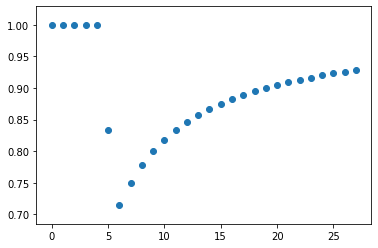

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5882352941176471
(104, 55)
2022-02-10 15:45:00
2022-02-16 15:30:00
(27, 15)
2022-02-16 15:45:00
2022-02-17 15:45:00
% Model match:  0.9259259259259259


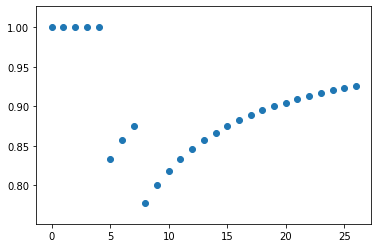

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(104, 55)
2022-02-11 09:45:00
2022-02-17 09:30:00
(51, 15)
2022-02-17 09:45:00
2022-02-18 15:45:00
% Model match:  0.6470588235294118


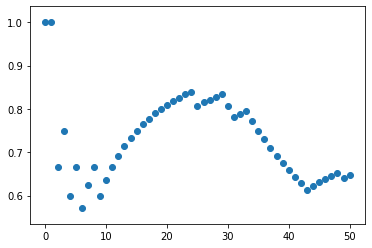

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7058823529411765
(104, 55)
2022-02-11 10:00:00
2022-02-17 09:45:00
(50, 15)
2022-02-17 10:00:00
2022-02-18 15:45:00
% Model match:  0.76


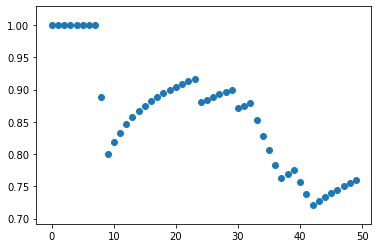

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(104, 55)
2022-02-11 10:15:00
2022-02-17 10:00:00
(49, 15)
2022-02-17 10:15:00
2022-02-18 15:45:00
% Model match:  0.7755102040816326


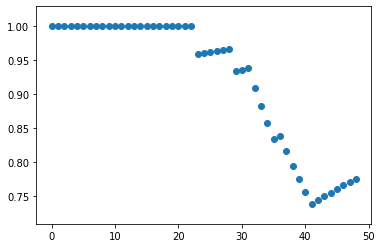

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7058823529411765
(104, 55)
2022-02-11 10:30:00
2022-02-17 10:15:00
(48, 15)
2022-02-17 10:30:00
2022-02-18 15:45:00
% Model match:  0.7291666666666666


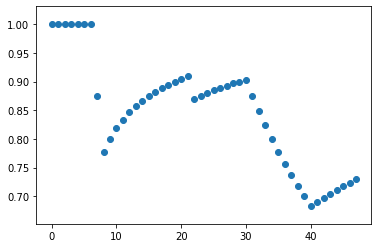

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(104, 55)
2022-02-11 10:45:00
2022-02-17 10:30:00
(47, 15)
2022-02-17 10:45:00
2022-02-18 15:45:00
% Model match:  0.723404255319149


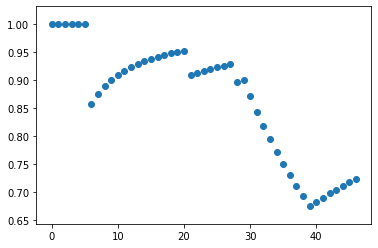

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7352941176470589
(104, 55)
2022-02-11 11:00:00
2022-02-17 10:45:00
(46, 15)
2022-02-17 11:00:00
2022-02-18 15:45:00
% Model match:  0.6739130434782609


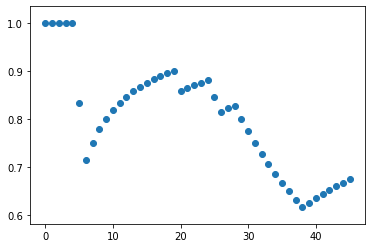

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(104, 55)
2022-02-11 11:15:00
2022-02-17 11:00:00
(45, 15)
2022-02-17 11:15:00
2022-02-18 15:45:00
% Model match:  0.6444444444444445


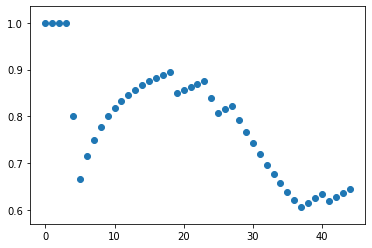

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6862745098039216
(104, 55)
2022-02-11 11:30:00
2022-02-17 11:15:00
(44, 15)
2022-02-17 11:30:00
2022-02-18 15:45:00
% Model match:  0.7045454545454546


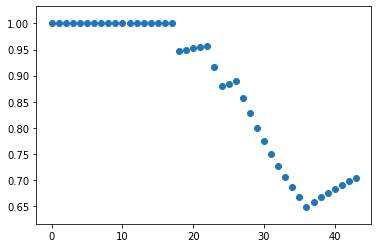

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(104, 55)
2022-02-11 11:45:00
2022-02-17 11:30:00
(43, 15)
2022-02-17 11:45:00
2022-02-18 15:45:00
% Model match:  0.6511627906976745


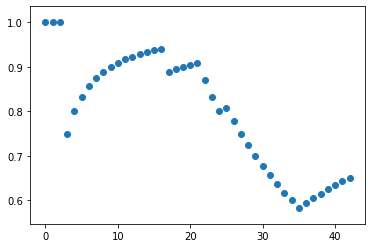

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6764705882352942
(104, 55)
2022-02-11 12:00:00
2022-02-17 11:45:00
(42, 15)
2022-02-17 12:00:00
2022-02-18 15:45:00
% Model match:  0.6666666666666666


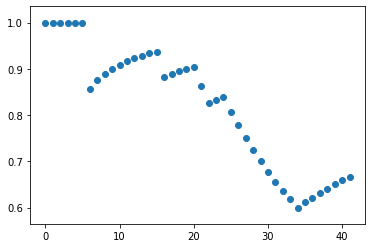

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(104, 55)
2022-02-11 12:15:00
2022-02-17 12:00:00
(41, 15)
2022-02-17 12:15:00
2022-02-18 15:45:00
% Model match:  0.7804878048780488


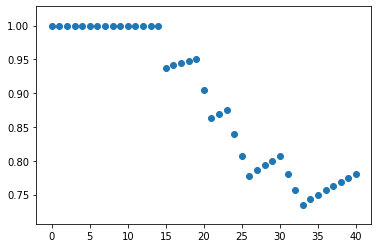

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7254901960784313
(104, 55)
2022-02-11 12:30:00
2022-02-17 12:15:00
(40, 15)
2022-02-17 12:30:00
2022-02-18 15:45:00
% Model match:  0.675


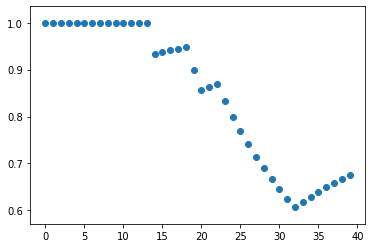

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(104, 55)
2022-02-11 12:45:00
2022-02-17 12:30:00
(39, 15)
2022-02-17 12:45:00
2022-02-18 15:45:00
% Model match:  0.6923076923076923


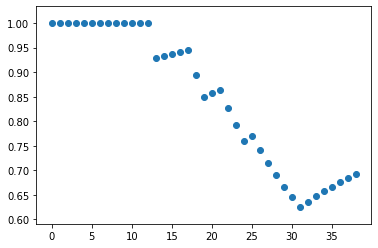

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7058823529411765
(104, 55)
2022-02-11 13:00:00
2022-02-17 12:45:00
(38, 15)
2022-02-17 13:00:00
2022-02-18 15:45:00
% Model match:  0.6578947368421053


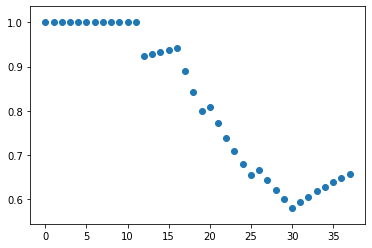

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(104, 55)
2022-02-11 13:15:00
2022-02-17 13:00:00
(37, 15)
2022-02-17 13:15:00
2022-02-18 15:45:00
% Model match:  0.7297297297297297


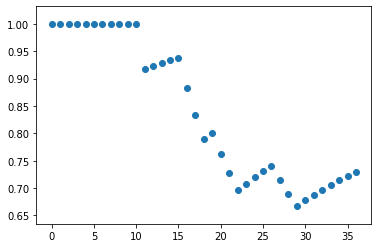

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7156862745098039
(104, 55)
2022-02-11 13:30:00
2022-02-17 13:15:00
(36, 15)
2022-02-17 13:30:00
2022-02-18 15:45:00
% Model match:  0.75


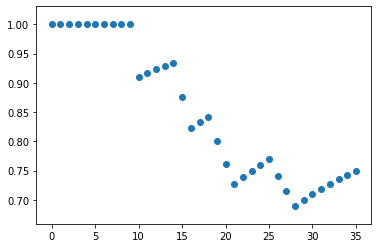

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(104, 55)
2022-02-11 13:45:00
2022-02-17 13:30:00
(35, 15)
2022-02-17 13:45:00
2022-02-18 15:45:00
% Model match:  0.6571428571428571


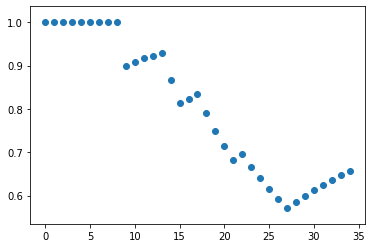

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7156862745098039
(104, 55)
2022-02-11 14:00:00
2022-02-17 13:45:00
(34, 15)
2022-02-17 14:00:00
2022-02-18 15:45:00
% Model match:  0.6176470588235294


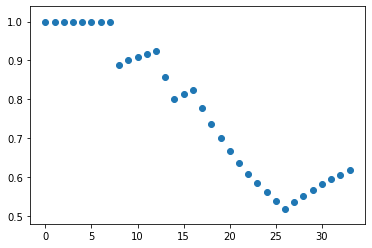

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(104, 55)
2022-02-11 14:15:00
2022-02-17 14:00:00
(33, 15)
2022-02-17 14:15:00
2022-02-18 15:45:00
% Model match:  0.6363636363636364


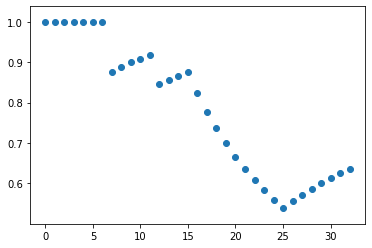

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7058823529411765
(104, 55)
2022-02-11 14:30:00
2022-02-17 14:15:00
(32, 15)
2022-02-17 14:30:00
2022-02-18 15:45:00
% Model match:  0.59375


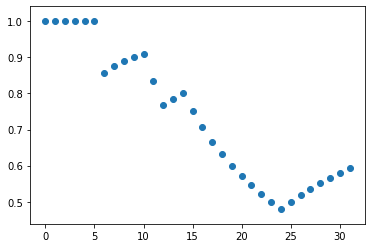

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6862745098039216
(104, 55)
2022-02-11 14:45:00
2022-02-17 14:30:00
(31, 15)
2022-02-17 14:45:00
2022-02-18 15:45:00
% Model match:  0.6774193548387096


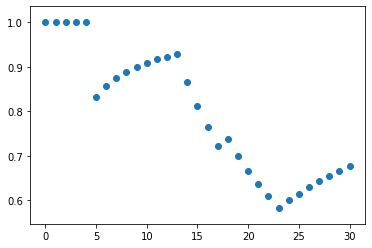

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6862745098039216
(104, 55)
2022-02-11 15:00:00
2022-02-17 14:45:00
(30, 15)
2022-02-17 15:00:00
2022-02-18 15:45:00
% Model match:  0.6333333333333333


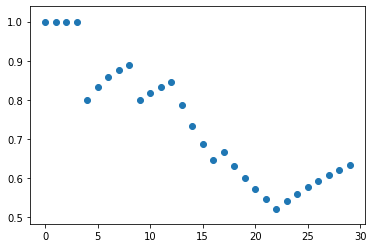

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(104, 55)
2022-02-11 15:15:00
2022-02-17 15:00:00
(29, 15)
2022-02-17 15:15:00
2022-02-18 15:45:00
% Model match:  0.6551724137931034


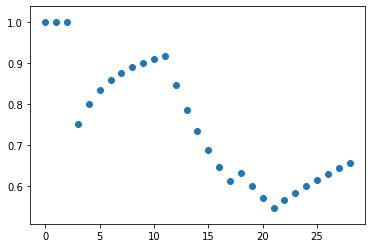

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.696078431372549
(104, 55)
2022-02-11 15:30:00
2022-02-17 15:15:00
(28, 15)
2022-02-17 15:30:00
2022-02-18 15:45:00
% Model match:  0.6785714285714286


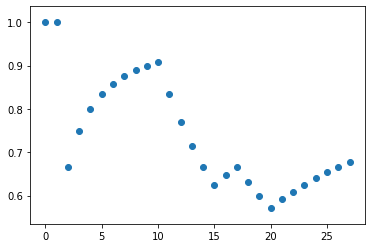

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6862745098039216
(104, 55)
2022-02-11 15:45:00
2022-02-17 15:30:00
(27, 15)
2022-02-17 15:45:00
2022-02-18 15:45:00
% Model match:  0.6296296296296297


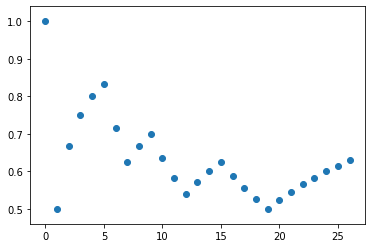

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(105, 55)
2022-02-14 09:30:00
2022-02-18 09:30:00
(25, 15)
2022-02-18 09:45:00
2022-02-18 15:45:00
% Model match:  0.68


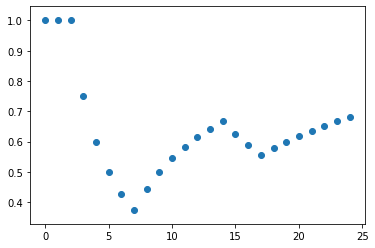

Number of splits for CV:  52
Fitting 52 folds for each of 1 candidates, totalling 52 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7019230769230769
(106, 55)
2022-02-14 09:30:00
2022-02-18 09:45:00
(24, 15)
2022-02-18 10:00:00
2022-02-18 15:45:00
% Model match:  0.625


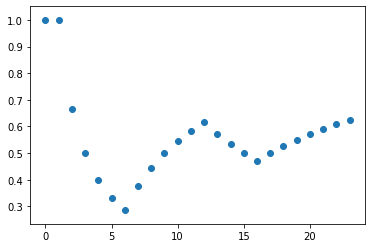

Number of splits for CV:  53
Fitting 53 folds for each of 1 candidates, totalling 53 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7924528301886793
(107, 55)
2022-02-14 09:30:00
2022-02-18 10:00:00
(23, 15)
2022-02-18 10:15:00
2022-02-18 15:45:00
% Model match:  0.6086956521739131


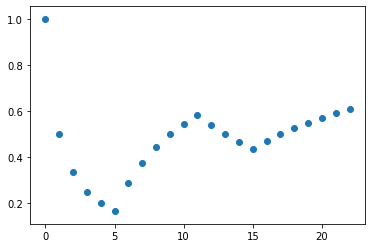

Number of splits for CV:  53
Fitting 53 folds for each of 1 candidates, totalling 53 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7075471698113207
(108, 55)
2022-02-14 09:30:00
2022-02-18 10:15:00
(22, 15)
2022-02-18 10:30:00
2022-02-18 15:45:00
% Model match:  0.5909090909090909


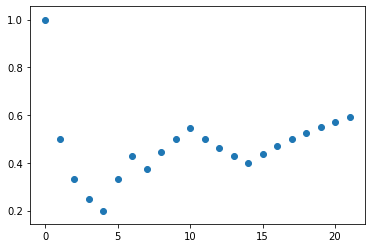

Number of splits for CV:  53
Fitting 53 folds for each of 1 candidates, totalling 53 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6320754716981132
(109, 55)
2022-02-14 09:30:00
2022-02-18 10:30:00
(21, 15)
2022-02-18 10:45:00
2022-02-18 15:45:00
% Model match:  0.6666666666666666


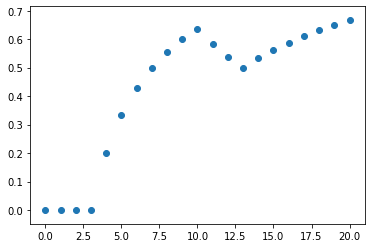

Number of splits for CV:  54
Fitting 54 folds for each of 1 candidates, totalling 54 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7037037037037037
(110, 55)
2022-02-14 09:30:00
2022-02-18 10:45:00
(20, 15)
2022-02-18 11:00:00
2022-02-18 15:45:00
% Model match:  0.55


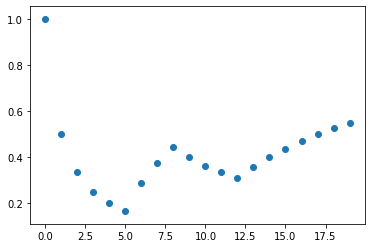

Number of splits for CV:  55
Fitting 55 folds for each of 1 candidates, totalling 55 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7636363636363637
(111, 55)
2022-02-14 09:30:00
2022-02-18 11:00:00
(19, 15)
2022-02-18 11:15:00
2022-02-18 15:45:00
% Model match:  0.6842105263157895


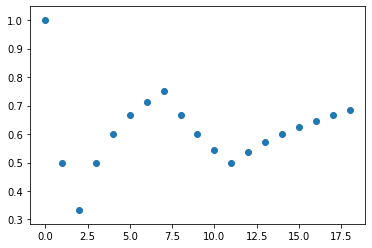

Number of splits for CV:  55
Fitting 55 folds for each of 1 candidates, totalling 55 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6909090909090909
(112, 55)
2022-02-14 09:30:00
2022-02-18 11:15:00
(18, 15)
2022-02-18 11:30:00
2022-02-18 15:45:00
% Model match:  0.4444444444444444


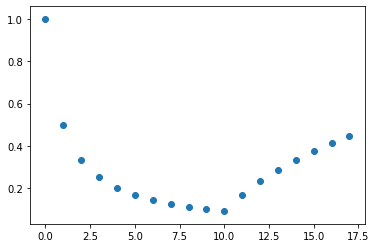

Number of splits for CV:  55
Fitting 55 folds for each of 1 candidates, totalling 55 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6090909090909091
(113, 55)
2022-02-14 09:30:00
2022-02-18 11:30:00
(17, 15)
2022-02-18 11:45:00
2022-02-18 15:45:00
% Model match:  0.4117647058823529


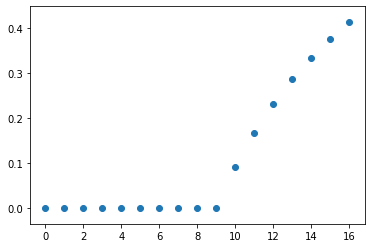

Number of splits for CV:  56
Fitting 56 folds for each of 1 candidates, totalling 56 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6875
(114, 55)
2022-02-14 09:30:00
2022-02-18 11:45:00
(16, 15)
2022-02-18 12:00:00
2022-02-18 15:45:00
% Model match:  0.4375


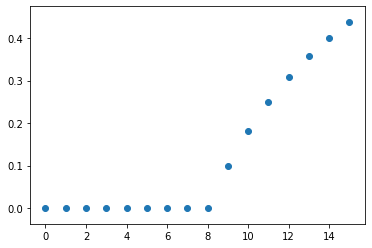

Number of splits for CV:  57
Fitting 57 folds for each of 1 candidates, totalling 57 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7192982456140351
(115, 55)
2022-02-14 09:30:00
2022-02-18 12:00:00
(15, 15)
2022-02-18 12:15:00
2022-02-18 15:45:00
% Model match:  0.4666666666666667


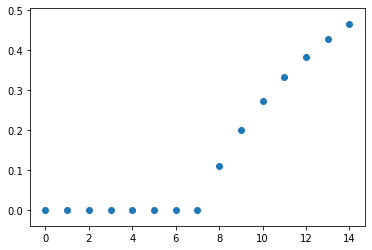

Number of splits for CV:  57
Fitting 57 folds for each of 1 candidates, totalling 57 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6754385964912281
(116, 55)
2022-02-14 09:30:00
2022-02-18 12:15:00
(14, 15)
2022-02-18 12:30:00
2022-02-18 15:45:00
% Model match:  0.7142857142857143


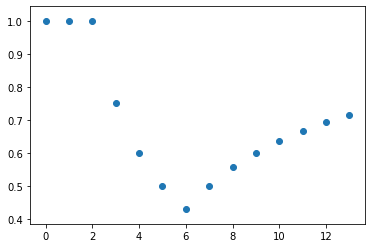

Number of splits for CV:  57
Fitting 57 folds for each of 1 candidates, totalling 57 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5877192982456141
(117, 55)
2022-02-14 09:30:00
2022-02-18 12:30:00
(13, 15)
2022-02-18 12:45:00
2022-02-18 15:45:00
% Model match:  0.7692307692307693


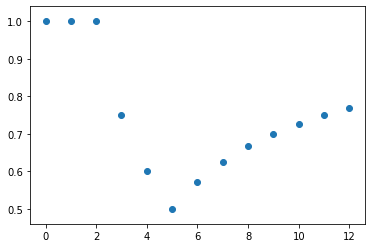

Number of splits for CV:  58
Fitting 58 folds for each of 1 candidates, totalling 58 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6637931034482759
(118, 55)
2022-02-14 09:30:00
2022-02-18 12:45:00
(12, 15)
2022-02-18 13:00:00
2022-02-18 15:45:00
% Model match:  0.8333333333333334


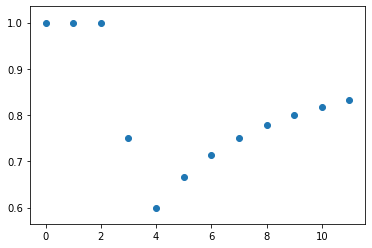

Number of splits for CV:  59
Fitting 59 folds for each of 1 candidates, totalling 59 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.711864406779661
(119, 55)
2022-02-14 09:30:00
2022-02-18 13:00:00
(11, 15)
2022-02-18 13:15:00
2022-02-18 15:45:00
% Model match:  0.8181818181818182


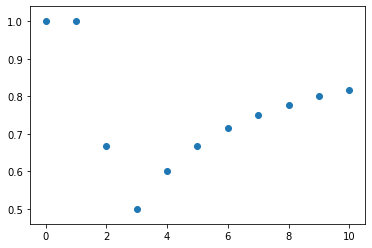

Number of splits for CV:  59
Fitting 59 folds for each of 1 candidates, totalling 59 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6694915254237288
(120, 55)
2022-02-14 09:30:00
2022-02-18 13:15:00
(10, 15)
2022-02-18 13:30:00
2022-02-18 15:45:00
% Model match:  0.9


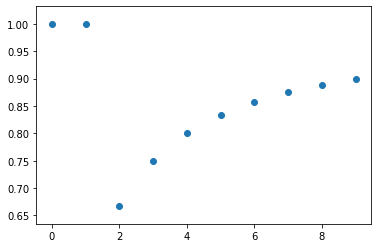

Number of splits for CV:  59
Fitting 59 folds for each of 1 candidates, totalling 59 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6016949152542372
(121, 55)
2022-02-14 09:30:00
2022-02-18 13:30:00
(9, 15)
2022-02-18 13:45:00
2022-02-18 15:45:00
% Model match:  1.0


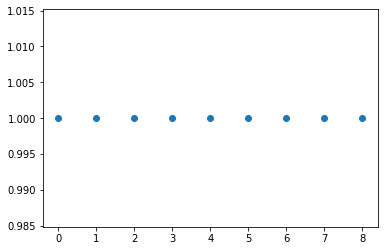

Number of splits for CV:  60
Fitting 60 folds for each of 1 candidates, totalling 60 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.675
(122, 55)
2022-02-14 09:30:00
2022-02-18 13:45:00
(8, 15)
2022-02-18 14:00:00
2022-02-18 15:45:00
% Model match:  0.875


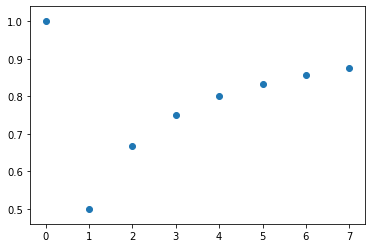

Number of splits for CV:  61
Fitting 61 folds for each of 1 candidates, totalling 61 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7213114754098361
(123, 55)
2022-02-14 09:30:00
2022-02-18 14:00:00
(7, 15)
2022-02-18 14:15:00
2022-02-18 15:45:00
% Model match:  0.8571428571428571


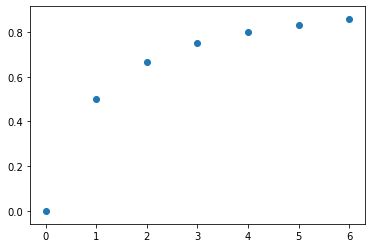

Number of splits for CV:  61
Fitting 61 folds for each of 1 candidates, totalling 61 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6721311475409836
(124, 55)
2022-02-14 09:30:00
2022-02-18 14:15:00
(6, 15)
2022-02-18 14:30:00
2022-02-18 15:45:00
% Model match:  1.0


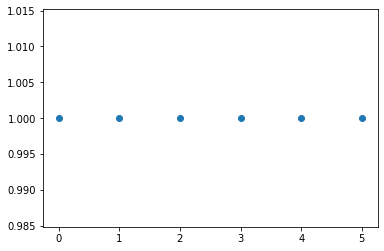

Number of splits for CV:  61
Fitting 61 folds for each of 1 candidates, totalling 61 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6065573770491803
(125, 55)
2022-02-14 09:30:00
2022-02-18 14:30:00
(5, 15)
2022-02-18 14:45:00
2022-02-18 15:45:00
% Model match:  1.0


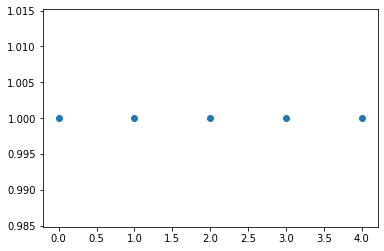

Number of splits for CV:  62
Fitting 62 folds for each of 1 candidates, totalling 62 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6693548387096774
(126, 55)
2022-02-14 09:30:00
2022-02-18 14:45:00
(4, 15)
2022-02-18 15:00:00
2022-02-18 15:45:00
% Model match:  1.0


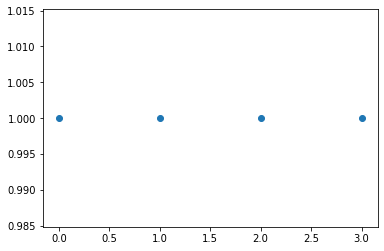

Number of splits for CV:  63
Fitting 63 folds for each of 1 candidates, totalling 63 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(127, 55)
2022-02-14 09:30:00
2022-02-18 15:00:00
(3, 15)
2022-02-18 15:15:00
2022-02-18 15:45:00
% Model match:  1.0


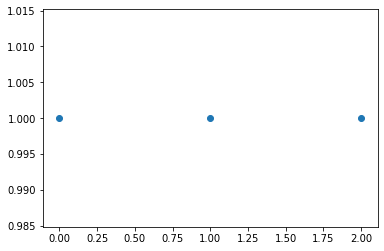

Number of splits for CV:  63
Fitting 63 folds for each of 1 candidates, totalling 63 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6587301587301587
(128, 55)
2022-02-14 09:30:00
2022-02-18 15:15:00
(2, 15)
2022-02-18 15:30:00
2022-02-18 15:45:00
% Model match:  1.0


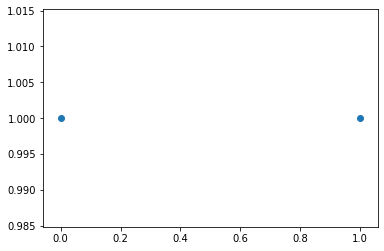

Number of splits for CV:  63
Fitting 63 folds for each of 1 candidates, totalling 63 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6111111111111112
(129, 55)
2022-02-14 09:30:00
2022-02-18 15:30:00
(1, 15)
2022-02-18 15:45:00
2022-02-18 15:45:00
% Model match:  1.0


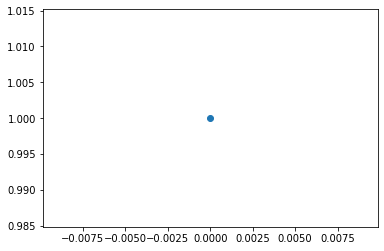

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6973684210526315
(78, 55)
2022-02-16 09:45:00
2022-02-22 09:30:00
(51, 15)
2022-02-22 09:45:00
2022-02-23 15:45:00
% Model match:  0.6862745098039216


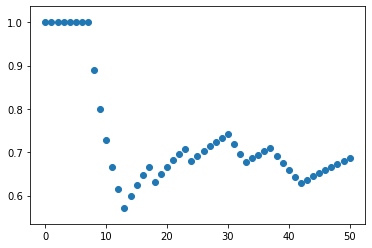

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7105263157894737
(78, 55)
2022-02-16 10:00:00
2022-02-22 09:45:00
(50, 15)
2022-02-22 10:00:00
2022-02-23 15:45:00
% Model match:  0.6


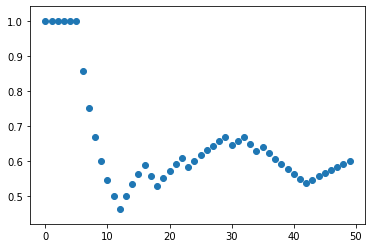

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6447368421052632
(78, 55)
2022-02-16 10:15:00
2022-02-22 10:00:00
(49, 15)
2022-02-22 10:15:00
2022-02-23 15:45:00
% Model match:  0.6326530612244898


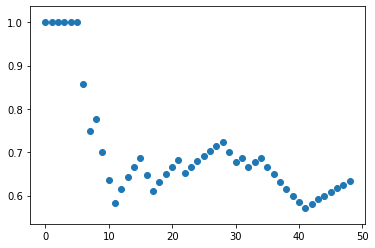

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6578947368421053
(78, 55)
2022-02-16 10:30:00
2022-02-22 10:15:00
(48, 15)
2022-02-22 10:30:00
2022-02-23 15:45:00
% Model match:  0.7083333333333334


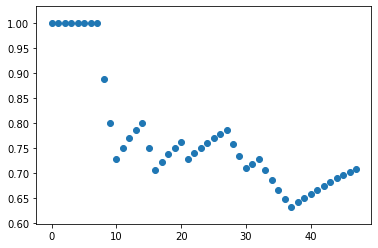

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6973684210526315
(78, 55)
2022-02-16 10:45:00
2022-02-22 10:30:00
(47, 15)
2022-02-22 10:45:00
2022-02-23 15:45:00
% Model match:  0.6170212765957447


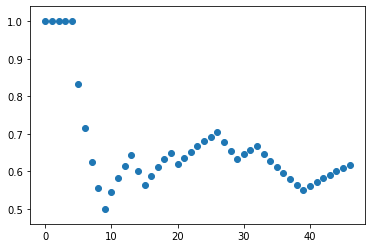

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6973684210526315
(78, 55)
2022-02-16 11:00:00
2022-02-22 10:45:00
(46, 15)
2022-02-22 11:00:00
2022-02-23 15:45:00
% Model match:  0.6521739130434783


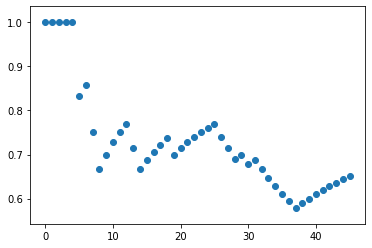

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6578947368421053
(78, 55)
2022-02-16 11:15:00
2022-02-22 11:00:00
(45, 15)
2022-02-22 11:15:00
2022-02-23 15:45:00
% Model match:  0.6


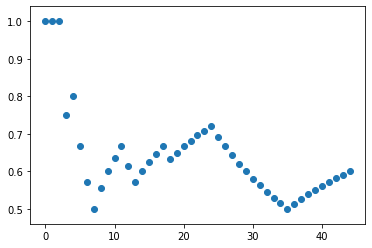

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6578947368421053
(78, 55)
2022-02-16 11:30:00
2022-02-22 11:15:00
(44, 15)
2022-02-22 11:30:00
2022-02-23 15:45:00
% Model match:  0.6136363636363636


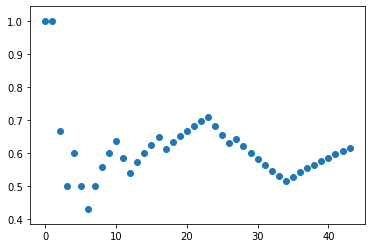

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6842105263157895
(78, 55)
2022-02-16 11:45:00
2022-02-22 11:30:00
(43, 15)
2022-02-22 11:45:00
2022-02-23 15:45:00
% Model match:  0.5348837209302325


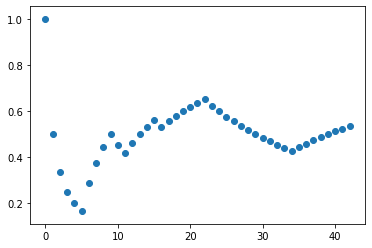

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6842105263157895
(78, 55)
2022-02-16 12:00:00
2022-02-22 11:45:00
(42, 15)
2022-02-22 12:00:00
2022-02-23 15:45:00
% Model match:  0.6904761904761905


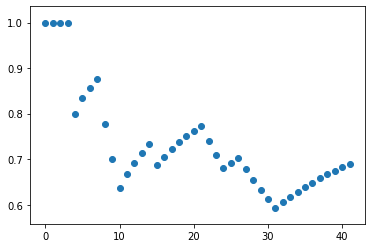

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6973684210526315
(78, 55)
2022-02-16 12:15:00
2022-02-22 12:00:00
(41, 15)
2022-02-22 12:15:00
2022-02-23 15:45:00
% Model match:  0.6829268292682927


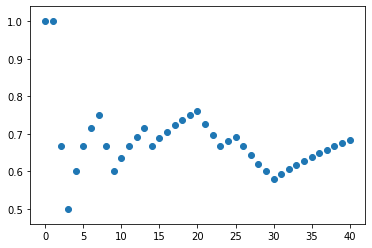

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6842105263157895
(78, 55)
2022-02-16 12:30:00
2022-02-22 12:15:00
(40, 15)
2022-02-22 12:30:00
2022-02-23 15:45:00
% Model match:  0.75


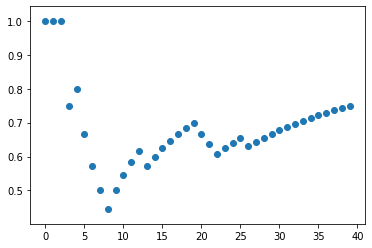

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6710526315789473
(78, 55)
2022-02-16 12:45:00
2022-02-22 12:30:00
(39, 15)
2022-02-22 12:45:00
2022-02-23 15:45:00
% Model match:  0.7948717948717948


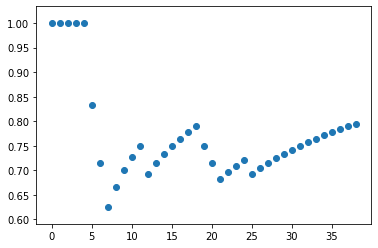

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6578947368421053
(78, 55)
2022-02-16 13:00:00
2022-02-22 12:45:00
(38, 15)
2022-02-22 13:00:00
2022-02-23 15:45:00
% Model match:  0.6842105263157895


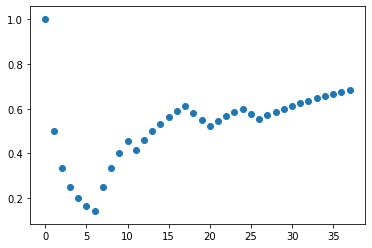

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7105263157894737
(78, 55)
2022-02-16 13:15:00
2022-02-22 13:00:00
(37, 15)
2022-02-22 13:15:00
2022-02-23 15:45:00
% Model match:  0.7297297297297297


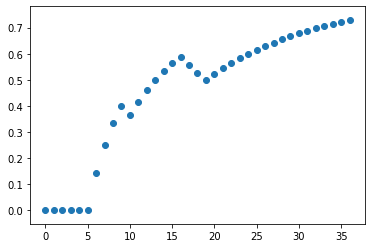

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7105263157894737
(78, 55)
2022-02-16 13:30:00
2022-02-22 13:15:00
(36, 15)
2022-02-22 13:30:00
2022-02-23 15:45:00
% Model match:  0.8611111111111112


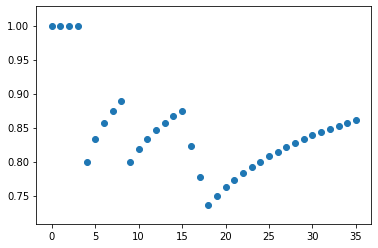

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6710526315789473
(78, 55)
2022-02-16 13:45:00
2022-02-22 13:30:00
(35, 15)
2022-02-22 13:45:00
2022-02-23 15:45:00
% Model match:  0.8857142857142857


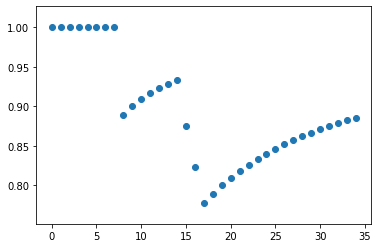

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6710526315789473
(78, 55)
2022-02-16 14:00:00
2022-02-22 13:45:00
(34, 15)
2022-02-22 14:00:00
2022-02-23 15:45:00
% Model match:  0.7352941176470589


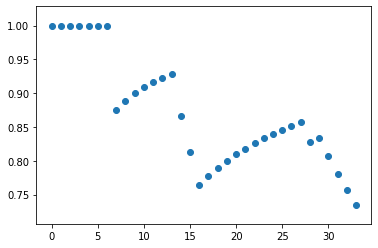

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6842105263157895
(78, 55)
2022-02-16 14:15:00
2022-02-22 14:00:00
(33, 15)
2022-02-22 14:15:00
2022-02-23 15:45:00
% Model match:  0.696969696969697


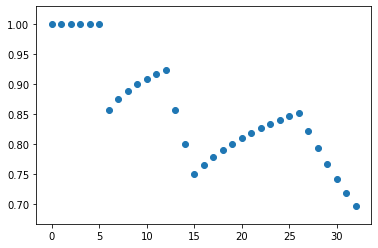

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6710526315789473
(78, 55)
2022-02-16 14:30:00
2022-02-22 14:15:00
(32, 15)
2022-02-22 14:30:00
2022-02-23 15:45:00
% Model match:  0.71875


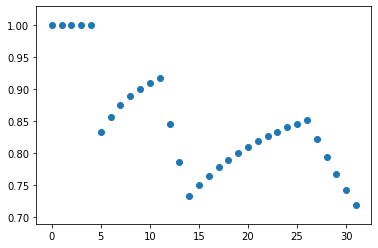

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6578947368421053
(78, 55)
2022-02-16 14:45:00
2022-02-22 14:30:00
(31, 15)
2022-02-22 14:45:00
2022-02-23 15:45:00
% Model match:  0.6451612903225806


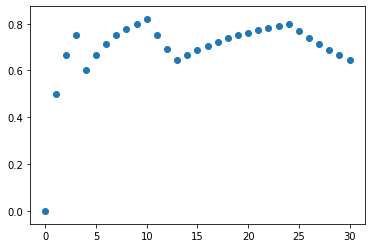

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6710526315789473
(78, 55)
2022-02-16 15:00:00
2022-02-22 14:45:00
(30, 15)
2022-02-22 15:00:00
2022-02-23 15:45:00
% Model match:  0.7333333333333333


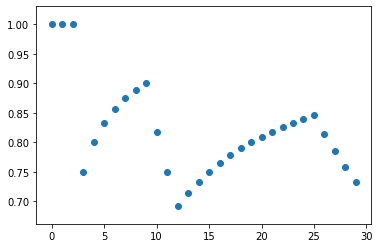

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6710526315789473
(78, 55)
2022-02-16 15:15:00
2022-02-22 15:00:00
(29, 15)
2022-02-22 15:15:00
2022-02-23 15:45:00
% Model match:  0.6551724137931034


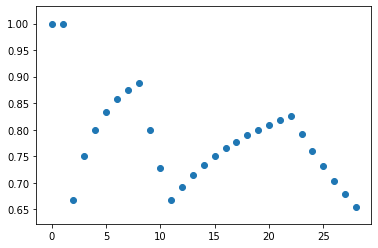

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6710526315789473
(78, 55)
2022-02-16 15:30:00
2022-02-22 15:15:00
(28, 15)
2022-02-22 15:30:00
2022-02-23 15:45:00
% Model match:  0.7142857142857143


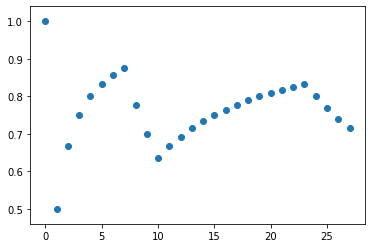

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6842105263157895
(78, 55)
2022-02-16 15:45:00
2022-02-22 15:30:00
(27, 15)
2022-02-22 15:45:00
2022-02-23 15:45:00
% Model match:  0.7037037037037037


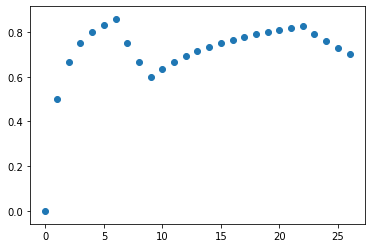

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7236842105263158
(78, 55)
2022-02-17 09:45:00
2022-02-23 09:30:00
(51, 15)
2022-02-23 09:45:00
2022-02-24 15:45:00
% Model match:  0.39215686274509803


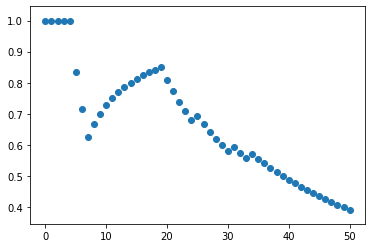

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.631578947368421
(78, 55)
2022-02-17 10:00:00
2022-02-23 09:45:00
(50, 15)
2022-02-23 10:00:00
2022-02-24 15:45:00
% Model match:  0.36


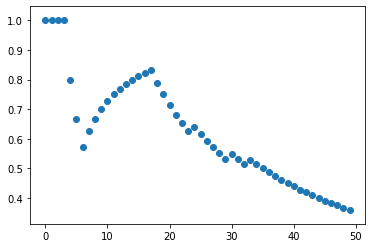

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6578947368421053
(78, 55)
2022-02-17 10:15:00
2022-02-23 10:00:00
(49, 15)
2022-02-23 10:15:00
2022-02-24 15:45:00
% Model match:  0.3469387755102041


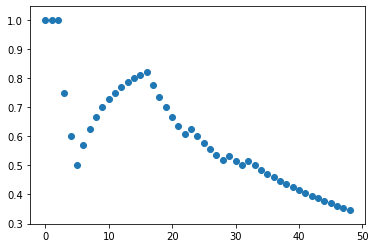

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.631578947368421
(78, 55)
2022-02-17 10:30:00
2022-02-23 10:15:00
(48, 15)
2022-02-23 10:30:00
2022-02-24 15:45:00
% Model match:  0.375


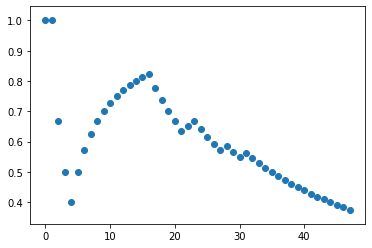

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6710526315789473
(78, 55)
2022-02-17 10:45:00
2022-02-23 10:30:00
(47, 15)
2022-02-23 10:45:00
2022-02-24 15:45:00
% Model match:  0.3617021276595745


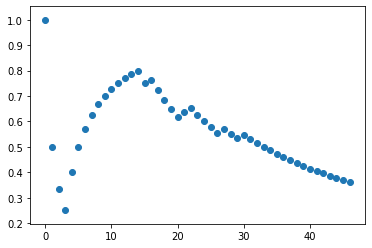

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.618421052631579
(78, 55)
2022-02-17 11:00:00
2022-02-23 10:45:00
(46, 15)
2022-02-23 11:00:00
2022-02-24 15:45:00
% Model match:  0.32608695652173914


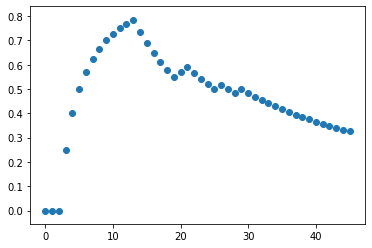

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.631578947368421
(78, 55)
2022-02-17 11:15:00
2022-02-23 11:00:00
(45, 15)
2022-02-23 11:15:00
2022-02-24 15:45:00
% Model match:  0.35555555555555557


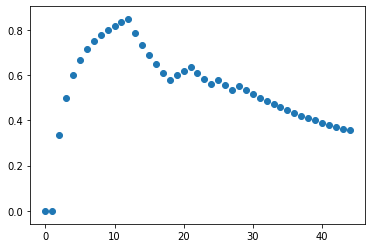

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5921052631578947
(78, 55)
2022-02-17 11:30:00
2022-02-23 11:15:00
(44, 15)
2022-02-23 11:30:00
2022-02-24 15:45:00
% Model match:  0.3181818181818182


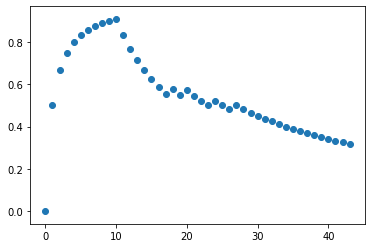

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.618421052631579
(78, 55)
2022-02-17 11:45:00
2022-02-23 11:30:00
(43, 15)
2022-02-23 11:45:00
2022-02-24 15:45:00
% Model match:  0.32558139534883723


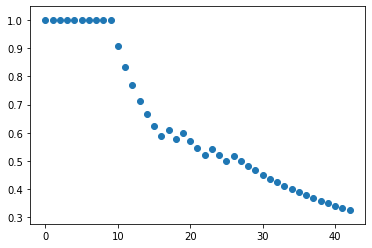

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5526315789473685
(78, 55)
2022-02-17 12:00:00
2022-02-23 11:45:00
(42, 15)
2022-02-23 12:00:00
2022-02-24 15:45:00
% Model match:  0.30952380952380953


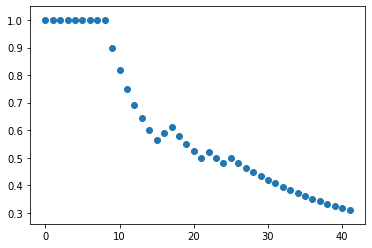

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6447368421052632
(78, 55)
2022-02-17 12:15:00
2022-02-23 12:00:00
(41, 15)
2022-02-23 12:15:00
2022-02-24 15:45:00
% Model match:  0.2682926829268293


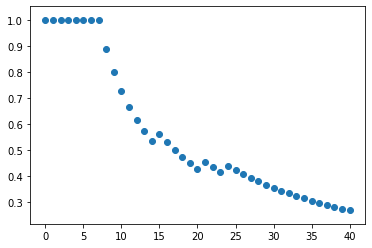

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5921052631578947
(78, 55)
2022-02-17 12:30:00
2022-02-23 12:15:00
(40, 15)
2022-02-23 12:30:00
2022-02-24 15:45:00
% Model match:  0.25


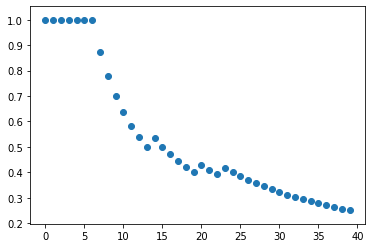

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.631578947368421
(78, 55)
2022-02-17 12:45:00
2022-02-23 12:30:00
(39, 15)
2022-02-23 12:45:00
2022-02-24 15:45:00
% Model match:  0.23076923076923078


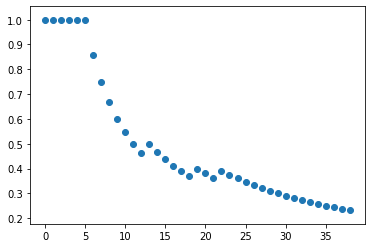

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6052631578947368
(78, 55)
2022-02-17 13:00:00
2022-02-23 12:45:00
(38, 15)
2022-02-23 13:00:00
2022-02-24 15:45:00
% Model match:  0.21052631578947367


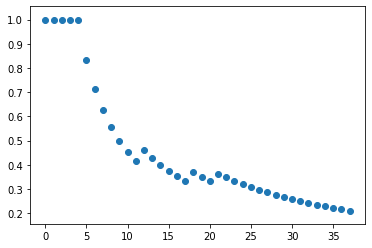

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5789473684210527
(78, 55)
2022-02-17 13:15:00
2022-02-23 13:00:00
(37, 15)
2022-02-23 13:15:00
2022-02-24 15:45:00
% Model match:  0.1891891891891892


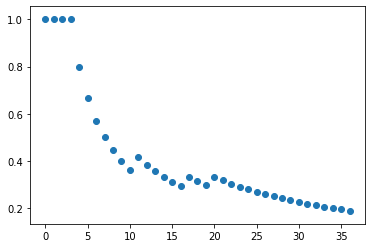

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.618421052631579
(78, 55)
2022-02-17 13:30:00
2022-02-23 13:15:00
(36, 15)
2022-02-23 13:30:00
2022-02-24 15:45:00
% Model match:  0.19444444444444445


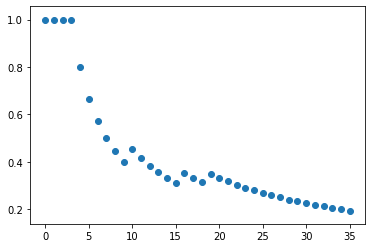

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.631578947368421
(78, 55)
2022-02-17 13:45:00
2022-02-23 13:30:00
(35, 15)
2022-02-23 13:45:00
2022-02-24 15:45:00
% Model match:  0.2571428571428571


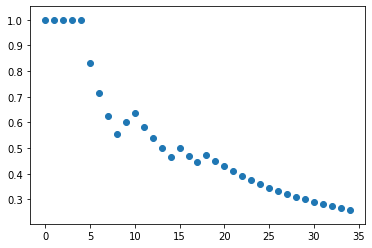

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5921052631578947
(78, 55)
2022-02-17 14:00:00
2022-02-23 13:45:00
(34, 15)
2022-02-23 14:00:00
2022-02-24 15:45:00
% Model match:  0.17647058823529413


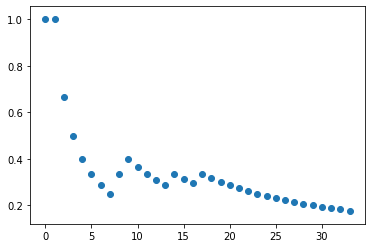

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.618421052631579
(78, 55)
2022-02-17 14:15:00
2022-02-23 14:00:00
(33, 15)
2022-02-23 14:15:00
2022-02-24 15:45:00
% Model match:  0.12121212121212122


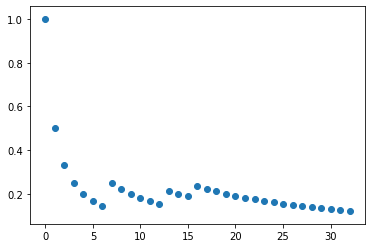

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6052631578947368
(78, 55)
2022-02-17 14:30:00
2022-02-23 14:15:00
(32, 15)
2022-02-23 14:30:00
2022-02-24 15:45:00
% Model match:  0.15625


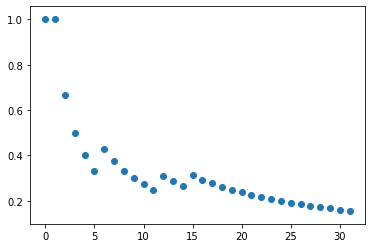

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6052631578947368
(78, 55)
2022-02-17 14:45:00
2022-02-23 14:30:00
(31, 15)
2022-02-23 14:45:00
2022-02-24 15:45:00
% Model match:  0.1935483870967742


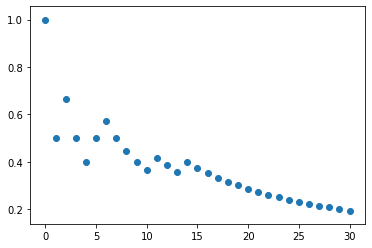

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.618421052631579
(78, 55)
2022-02-17 15:00:00
2022-02-23 14:45:00
(30, 15)
2022-02-23 15:00:00
2022-02-24 15:45:00
% Model match:  0.23333333333333334


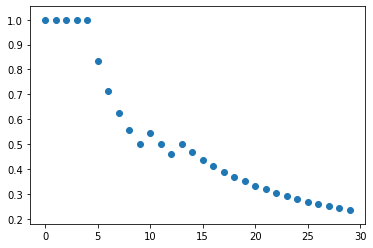

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5789473684210527
(78, 55)
2022-02-17 15:15:00
2022-02-23 15:00:00
(29, 15)
2022-02-23 15:15:00
2022-02-24 15:45:00
% Model match:  0.20689655172413793


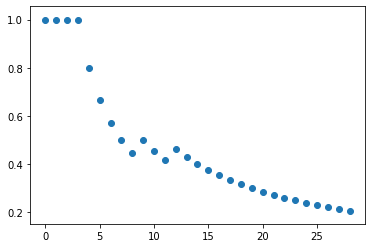

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.631578947368421
(78, 55)
2022-02-17 15:30:00
2022-02-23 15:15:00
(28, 15)
2022-02-23 15:30:00
2022-02-24 15:45:00
% Model match:  0.21428571428571427


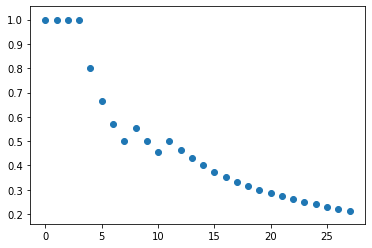

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6447368421052632
(78, 55)
2022-02-17 15:45:00
2022-02-23 15:30:00
(27, 15)
2022-02-23 15:45:00
2022-02-24 15:45:00
% Model match:  0.14814814814814814


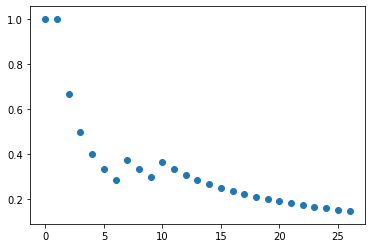

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6447368421052632
(78, 55)
2022-02-18 09:45:00
2022-02-24 09:30:00
(51, 15)
2022-02-24 09:45:00
2022-02-25 15:45:00
% Model match:  0.35294117647058826


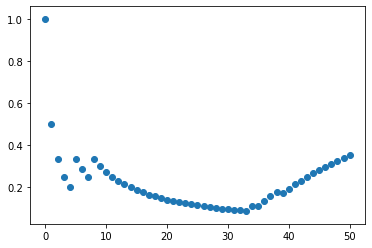

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5921052631578947
(78, 55)
2022-02-18 10:00:00
2022-02-24 09:45:00
(50, 15)
2022-02-24 10:00:00
2022-02-25 15:45:00
% Model match:  0.4


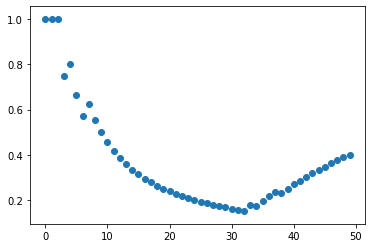

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5789473684210527
(78, 55)
2022-02-18 10:15:00
2022-02-24 10:00:00
(49, 15)
2022-02-24 10:15:00
2022-02-25 15:45:00
% Model match:  0.40816326530612246


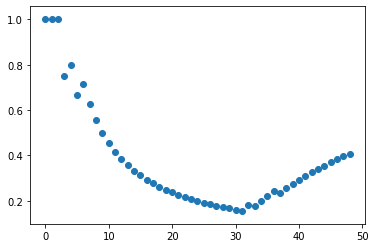

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5657894736842105
(78, 55)
2022-02-18 10:30:00
2022-02-24 10:15:00
(48, 15)
2022-02-24 10:30:00
2022-02-25 15:45:00
% Model match:  0.4166666666666667


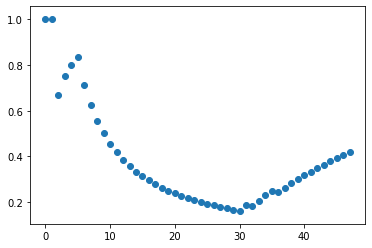

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6052631578947368
(78, 55)
2022-02-18 10:45:00
2022-02-24 10:30:00
(47, 15)
2022-02-24 10:45:00
2022-02-25 15:45:00
% Model match:  0.3829787234042553


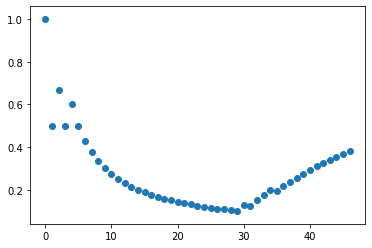

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5921052631578947
(78, 55)
2022-02-18 11:00:00
2022-02-24 10:45:00
(46, 15)
2022-02-24 11:00:00
2022-02-25 15:45:00
% Model match:  0.3695652173913043


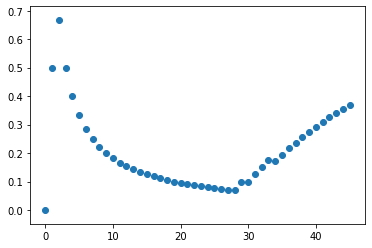

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6052631578947368
(78, 55)
2022-02-18 11:15:00
2022-02-24 11:00:00
(45, 15)
2022-02-24 11:15:00
2022-02-25 15:45:00
% Model match:  0.35555555555555557


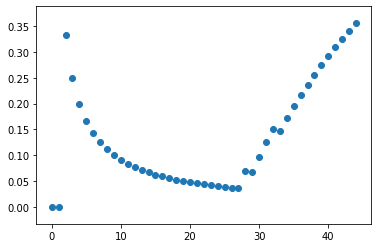

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.631578947368421
(78, 55)
2022-02-18 11:30:00
2022-02-24 11:15:00
(44, 15)
2022-02-24 11:30:00
2022-02-25 15:45:00
% Model match:  0.4090909090909091


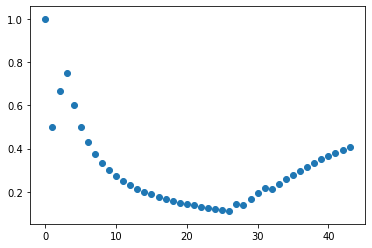

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.618421052631579
(78, 55)
2022-02-18 11:45:00
2022-02-24 11:30:00
(43, 15)
2022-02-24 11:45:00
2022-02-25 15:45:00
% Model match:  0.3488372093023256


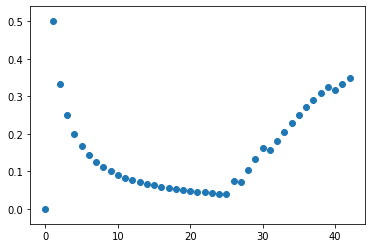

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5921052631578947
(78, 55)
2022-02-18 12:00:00
2022-02-24 11:45:00
(42, 15)
2022-02-24 12:00:00
2022-02-25 15:45:00
% Model match:  0.35714285714285715


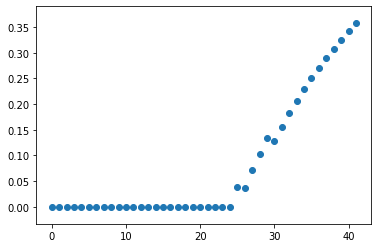

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.618421052631579
(78, 55)
2022-02-18 12:15:00
2022-02-24 12:00:00
(41, 15)
2022-02-24 12:15:00
2022-02-25 15:45:00
% Model match:  0.36585365853658536


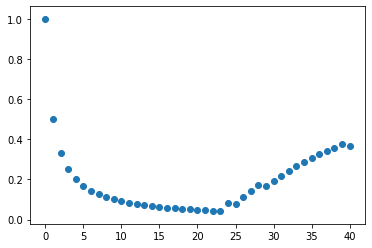

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5921052631578947
(78, 55)
2022-02-18 12:30:00
2022-02-24 12:15:00
(40, 15)
2022-02-24 12:30:00
2022-02-25 15:45:00
% Model match:  0.425


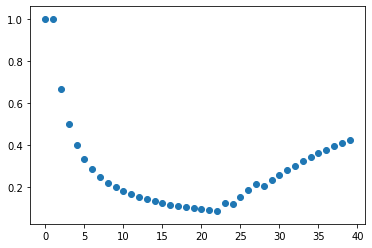

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.631578947368421
(78, 55)
2022-02-18 12:45:00
2022-02-24 12:30:00
(39, 15)
2022-02-24 12:45:00
2022-02-25 15:45:00
% Model match:  0.4358974358974359


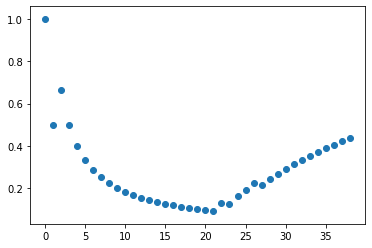

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5394736842105263
(78, 55)
2022-02-18 13:00:00
2022-02-24 12:45:00
(38, 15)
2022-02-24 13:00:00
2022-02-25 15:45:00
% Model match:  0.4473684210526316


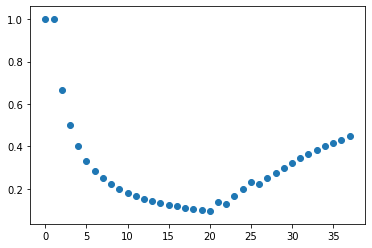

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5657894736842105
(78, 55)
2022-02-18 13:15:00
2022-02-24 13:00:00
(37, 15)
2022-02-24 13:15:00
2022-02-25 15:45:00
% Model match:  0.4864864864864865


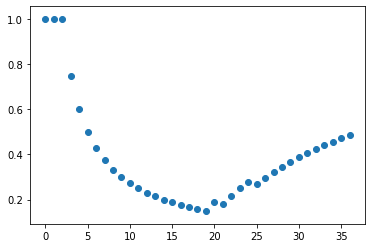

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5526315789473685
(78, 55)
2022-02-18 13:30:00
2022-02-24 13:15:00
(36, 15)
2022-02-24 13:30:00
2022-02-25 15:45:00
% Model match:  0.4722222222222222


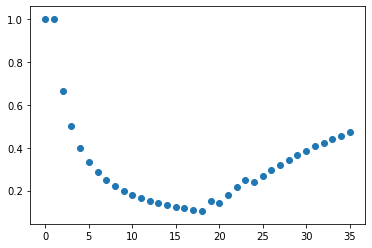

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5657894736842105
(78, 55)
2022-02-18 13:45:00
2022-02-24 13:30:00
(35, 15)
2022-02-24 13:45:00
2022-02-25 15:45:00
% Model match:  0.4857142857142857


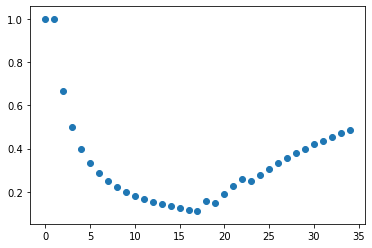

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5526315789473685
(78, 55)
2022-02-18 14:00:00
2022-02-24 13:45:00
(34, 15)
2022-02-24 14:00:00
2022-02-25 15:45:00
% Model match:  0.47058823529411764


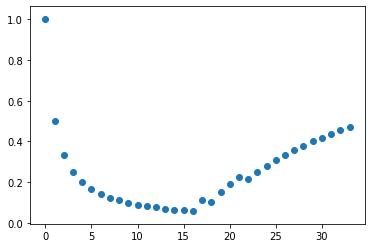

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.618421052631579
(78, 55)
2022-02-18 14:15:00
2022-02-24 14:00:00
(33, 15)
2022-02-24 14:15:00
2022-02-25 15:45:00
% Model match:  0.45454545454545453


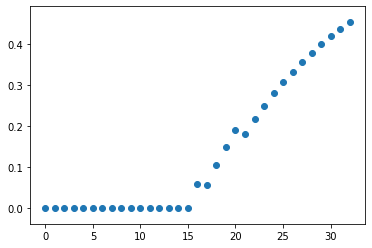

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5394736842105263
(78, 55)
2022-02-18 14:30:00
2022-02-24 14:15:00
(32, 15)
2022-02-24 14:30:00
2022-02-25 15:45:00
% Model match:  0.5


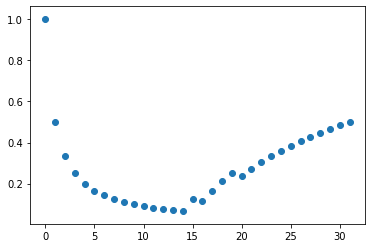

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6052631578947368
(78, 55)
2022-02-18 14:45:00
2022-02-24 14:30:00
(31, 15)
2022-02-24 14:45:00
2022-02-25 15:45:00
% Model match:  0.5161290322580645


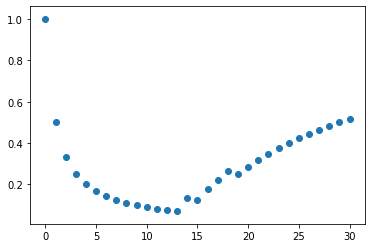

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5657894736842105
(78, 55)
2022-02-18 15:00:00
2022-02-24 14:45:00
(30, 15)
2022-02-24 15:00:00
2022-02-25 15:45:00
% Model match:  0.5333333333333333


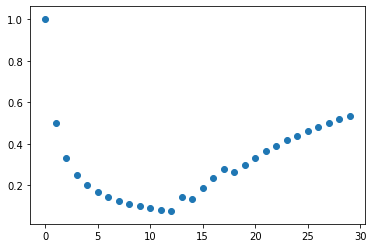

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5789473684210527
(78, 55)
2022-02-18 15:15:00
2022-02-24 15:00:00
(29, 15)
2022-02-24 15:15:00
2022-02-25 15:45:00
% Model match:  0.6206896551724138


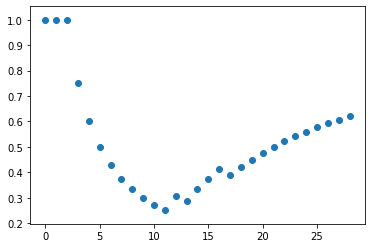

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5789473684210527
(78, 55)
2022-02-18 15:30:00
2022-02-24 15:15:00
(28, 15)
2022-02-24 15:30:00
2022-02-25 15:45:00
% Model match:  0.6785714285714286


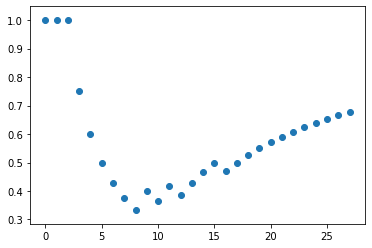

Number of splits for CV:  38
Fitting 38 folds for each of 1 candidates, totalling 38 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6447368421052632
(78, 55)
2022-02-18 15:45:00
2022-02-24 15:30:00
(27, 15)
2022-02-24 15:45:00
2022-02-25 15:45:00
% Model match:  0.5555555555555556


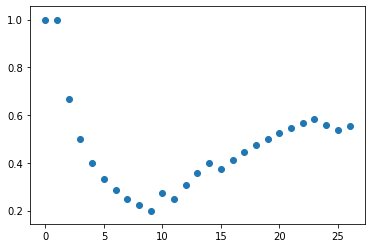

Number of splits for CV:  39
Fitting 39 folds for each of 1 candidates, totalling 39 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6410256410256411
(79, 55)
2022-02-22 09:30:00
2022-02-25 09:30:00
(25, 15)
2022-02-25 09:45:00
2022-02-25 15:45:00
% Model match:  0.64


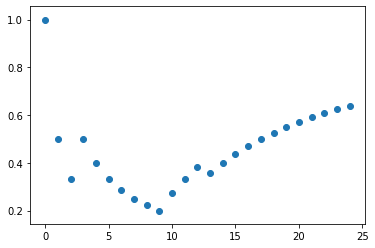

Number of splits for CV:  39
Fitting 39 folds for each of 1 candidates, totalling 39 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5512820512820513
(80, 55)
2022-02-22 09:30:00
2022-02-25 09:45:00
(24, 15)
2022-02-25 10:00:00
2022-02-25 15:45:00
% Model match:  0.8333333333333334


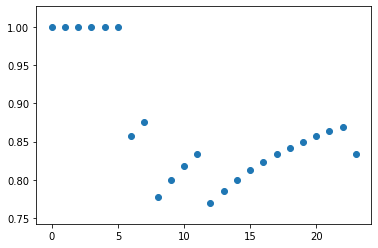

Number of splits for CV:  39
Fitting 39 folds for each of 1 candidates, totalling 39 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6025641025641025
(81, 55)
2022-02-22 09:30:00
2022-02-25 10:00:00
(23, 15)
2022-02-25 10:15:00
2022-02-25 15:45:00
% Model match:  0.782608695652174


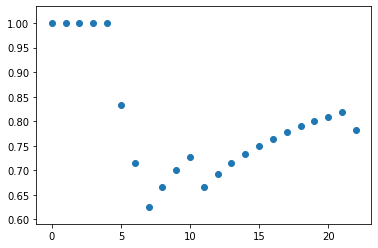

Number of splits for CV:  40
Fitting 40 folds for each of 1 candidates, totalling 40 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5625
(82, 55)
2022-02-22 09:30:00
2022-02-25 10:15:00
(22, 15)
2022-02-25 10:30:00
2022-02-25 15:45:00
% Model match:  0.8636363636363636


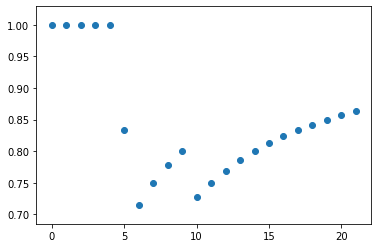

Number of splits for CV:  41
Fitting 41 folds for each of 1 candidates, totalling 41 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6585365853658537
(83, 55)
2022-02-22 09:30:00
2022-02-25 10:30:00
(21, 15)
2022-02-25 10:45:00
2022-02-25 15:45:00
% Model match:  0.9047619047619048


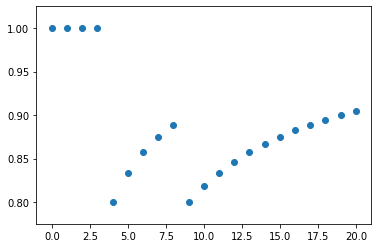

Number of splits for CV:  41
Fitting 41 folds for each of 1 candidates, totalling 41 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.573170731707317
(84, 55)
2022-02-22 09:30:00
2022-02-25 10:45:00
(20, 15)
2022-02-25 11:00:00
2022-02-25 15:45:00
% Model match:  0.85


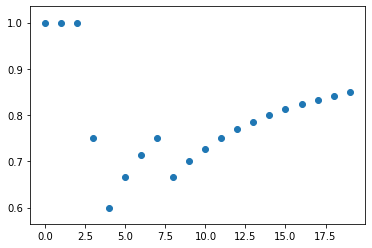

Number of splits for CV:  41
Fitting 41 folds for each of 1 candidates, totalling 41 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6219512195121951
(85, 55)
2022-02-22 09:30:00
2022-02-25 11:00:00
(19, 15)
2022-02-25 11:15:00
2022-02-25 15:45:00
% Model match:  0.8421052631578947


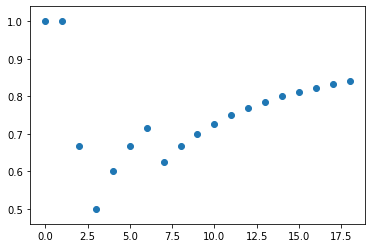

Number of splits for CV:  42
Fitting 42 folds for each of 1 candidates, totalling 42 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5714285714285714
(86, 55)
2022-02-22 09:30:00
2022-02-25 11:15:00
(18, 15)
2022-02-25 11:30:00
2022-02-25 15:45:00
% Model match:  0.7777777777777778


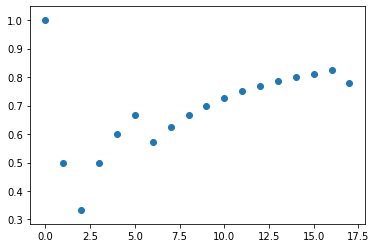

Number of splits for CV:  43
Fitting 43 folds for each of 1 candidates, totalling 43 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.627906976744186
(87, 55)
2022-02-22 09:30:00
2022-02-25 11:30:00
(17, 15)
2022-02-25 11:45:00
2022-02-25 15:45:00
% Model match:  0.7058823529411765


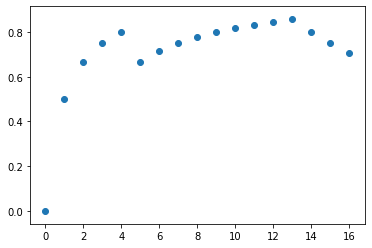

Number of splits for CV:  43
Fitting 43 folds for each of 1 candidates, totalling 43 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5581395348837209
(88, 55)
2022-02-22 09:30:00
2022-02-25 11:45:00
(16, 15)
2022-02-25 12:00:00
2022-02-25 15:45:00
% Model match:  0.8125


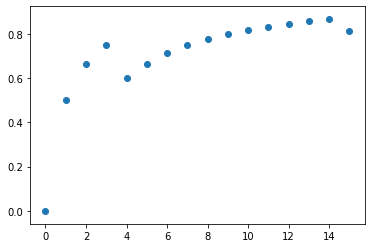

Number of splits for CV:  43
Fitting 43 folds for each of 1 candidates, totalling 43 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6046511627906976
(89, 55)
2022-02-22 09:30:00
2022-02-25 12:00:00
(15, 15)
2022-02-25 12:15:00
2022-02-25 15:45:00
% Model match:  0.8


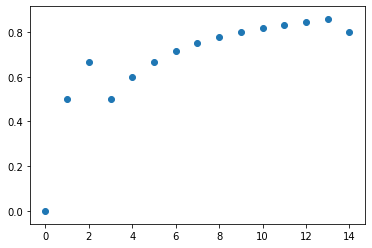

Number of splits for CV:  44
Fitting 44 folds for each of 1 candidates, totalling 44 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5454545454545454
(90, 55)
2022-02-22 09:30:00
2022-02-25 12:15:00
(14, 15)
2022-02-25 12:30:00
2022-02-25 15:45:00
% Model match:  0.9285714285714286


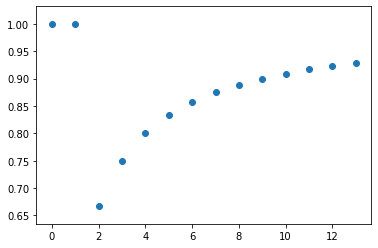

Number of splits for CV:  45
Fitting 45 folds for each of 1 candidates, totalling 45 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5777777777777777
(91, 55)
2022-02-22 09:30:00
2022-02-25 12:30:00
(13, 15)
2022-02-25 12:45:00
2022-02-25 15:45:00
% Model match:  0.9230769230769231


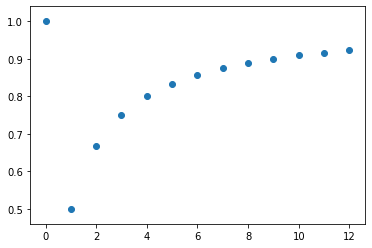

Number of splits for CV:  45
Fitting 45 folds for each of 1 candidates, totalling 45 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5444444444444444
(92, 55)
2022-02-22 09:30:00
2022-02-25 12:45:00
(12, 15)
2022-02-25 13:00:00
2022-02-25 15:45:00
% Model match:  0.9166666666666666


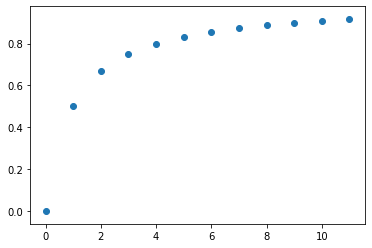

Number of splits for CV:  45
Fitting 45 folds for each of 1 candidates, totalling 45 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5888888888888889
(93, 55)
2022-02-22 09:30:00
2022-02-25 13:00:00
(11, 15)
2022-02-25 13:15:00
2022-02-25 15:45:00
% Model match:  1.0


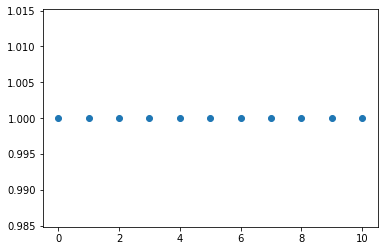

Number of splits for CV:  46
Fitting 46 folds for each of 1 candidates, totalling 46 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5434782608695652
(94, 55)
2022-02-22 09:30:00
2022-02-25 13:15:00
(10, 15)
2022-02-25 13:30:00
2022-02-25 15:45:00
% Model match:  1.0


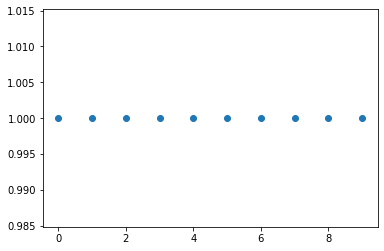

Number of splits for CV:  47
Fitting 47 folds for each of 1 candidates, totalling 47 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6170212765957447
(95, 55)
2022-02-22 09:30:00
2022-02-25 13:30:00
(9, 15)
2022-02-25 13:45:00
2022-02-25 15:45:00
% Model match:  1.0


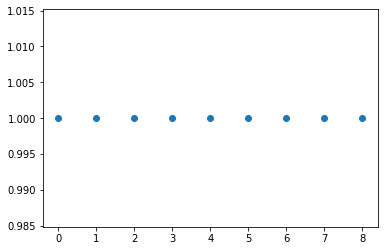

Number of splits for CV:  47
Fitting 47 folds for each of 1 candidates, totalling 47 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5531914893617021
(96, 55)
2022-02-22 09:30:00
2022-02-25 13:45:00
(8, 15)
2022-02-25 14:00:00
2022-02-25 15:45:00
% Model match:  1.0


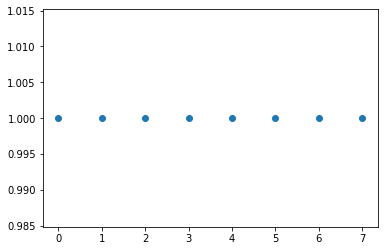

Number of splits for CV:  47
Fitting 47 folds for each of 1 candidates, totalling 47 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6063829787234043
(97, 55)
2022-02-22 09:30:00
2022-02-25 14:00:00
(7, 15)
2022-02-25 14:15:00
2022-02-25 15:45:00
% Model match:  1.0


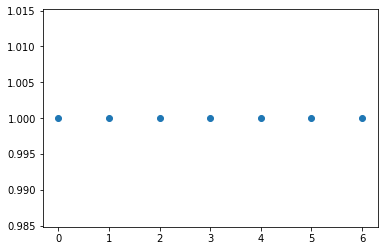

Number of splits for CV:  48
Fitting 48 folds for each of 1 candidates, totalling 48 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5625
(98, 55)
2022-02-22 09:30:00
2022-02-25 14:15:00
(6, 15)
2022-02-25 14:30:00
2022-02-25 15:45:00
% Model match:  1.0


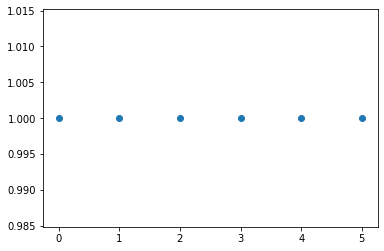

Number of splits for CV:  49
Fitting 49 folds for each of 1 candidates, totalling 49 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6326530612244898
(99, 55)
2022-02-22 09:30:00
2022-02-25 14:30:00
(5, 15)
2022-02-25 14:45:00
2022-02-25 15:45:00
% Model match:  1.0


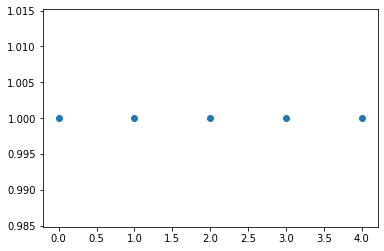

Number of splits for CV:  49
Fitting 49 folds for each of 1 candidates, totalling 49 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5714285714285714
(100, 55)
2022-02-22 09:30:00
2022-02-25 14:45:00
(4, 15)
2022-02-25 15:00:00
2022-02-25 15:45:00
% Model match:  1.0


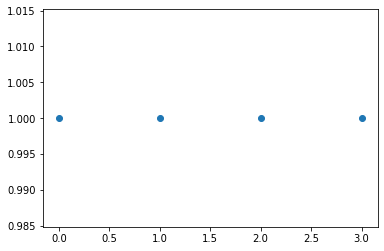

Number of splits for CV:  49
Fitting 49 folds for each of 1 candidates, totalling 49 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6224489795918368
(101, 55)
2022-02-22 09:30:00
2022-02-25 15:00:00
(3, 15)
2022-02-25 15:15:00
2022-02-25 15:45:00
% Model match:  1.0


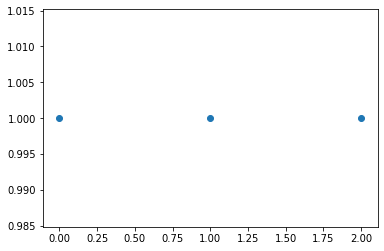

Number of splits for CV:  50
Fitting 50 folds for each of 1 candidates, totalling 50 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.58
(102, 55)
2022-02-22 09:30:00
2022-02-25 15:15:00
(2, 15)
2022-02-25 15:30:00
2022-02-25 15:45:00
% Model match:  1.0


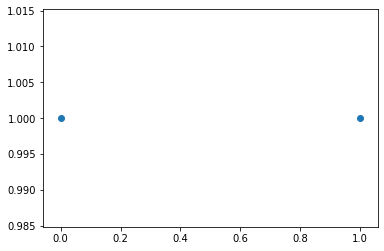

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(103, 55)
2022-02-22 09:30:00
2022-02-25 15:30:00
(1, 15)
2022-02-25 15:45:00
2022-02-25 15:45:00
% Model match:  1.0


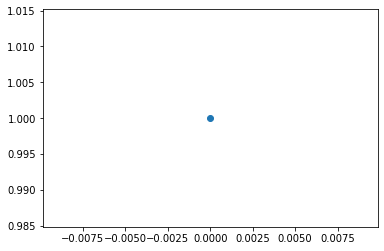

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(104, 55)
2022-02-22 09:45:00
2022-02-28 09:30:00
(51, 15)
2022-02-28 09:45:00
2022-03-01 15:45:00
% Model match:  0.49019607843137253


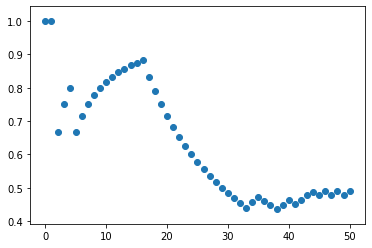

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(104, 55)
2022-02-22 10:00:00
2022-02-28 09:45:00
(50, 15)
2022-02-28 10:00:00
2022-03-01 15:45:00
% Model match:  0.52


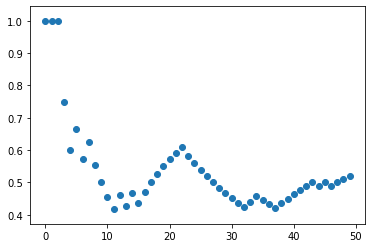

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(104, 55)
2022-02-22 10:15:00
2022-02-28 10:00:00
(49, 15)
2022-02-28 10:15:00
2022-03-01 15:45:00
% Model match:  0.5306122448979592


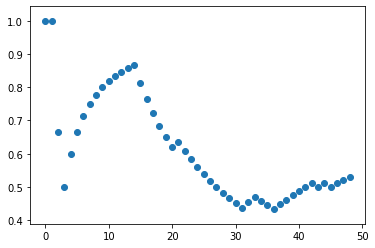

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(104, 55)
2022-02-22 10:30:00
2022-02-28 10:15:00
(48, 15)
2022-02-28 10:30:00
2022-03-01 15:45:00
% Model match:  0.4583333333333333


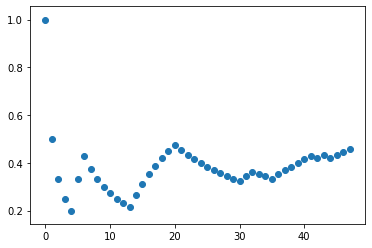

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6764705882352942
(104, 55)
2022-02-22 10:45:00
2022-02-28 10:30:00
(47, 15)
2022-02-28 10:45:00
2022-03-01 15:45:00
% Model match:  0.44680851063829785


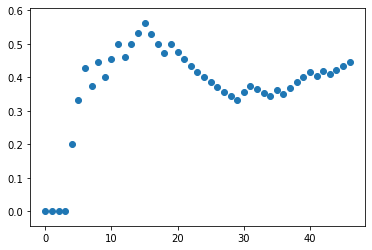

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(104, 55)
2022-02-22 11:00:00
2022-02-28 10:45:00
(46, 15)
2022-02-28 11:00:00
2022-03-01 15:45:00
% Model match:  0.5434782608695652


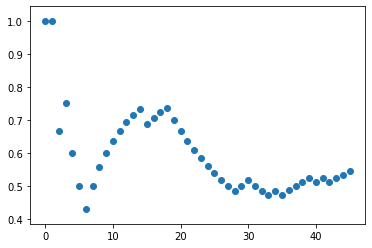

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(104, 55)
2022-02-22 11:15:00
2022-02-28 11:00:00
(45, 15)
2022-02-28 11:15:00
2022-03-01 15:45:00
% Model match:  0.4888888888888889


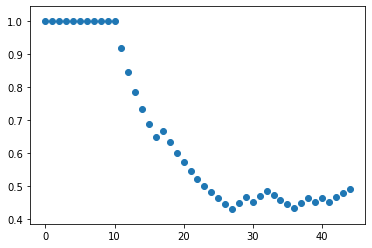

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(104, 55)
2022-02-22 11:30:00
2022-02-28 11:15:00
(44, 15)
2022-02-28 11:30:00
2022-03-01 15:45:00
% Model match:  0.45454545454545453


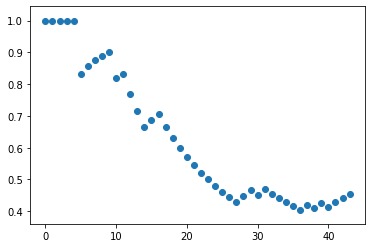

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(104, 55)
2022-02-22 11:45:00
2022-02-28 11:30:00
(43, 15)
2022-02-28 11:45:00
2022-03-01 15:45:00
% Model match:  0.4883720930232558


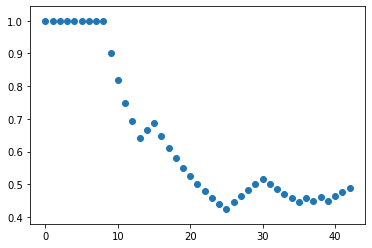

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(104, 55)
2022-02-22 12:00:00
2022-02-28 11:45:00
(42, 15)
2022-02-28 12:00:00
2022-03-01 15:45:00
% Model match:  0.47619047619047616


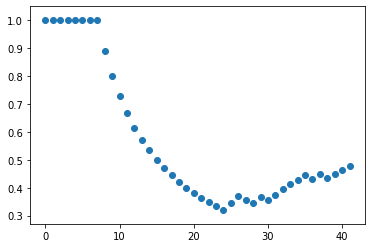

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(104, 55)
2022-02-22 12:15:00
2022-02-28 12:00:00
(41, 15)
2022-02-28 12:15:00
2022-03-01 15:45:00
% Model match:  0.43902439024390244


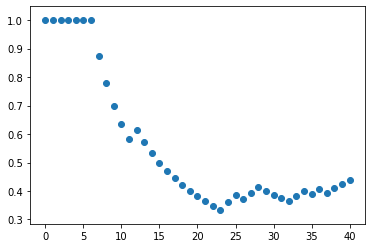

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5980392156862745
(104, 55)
2022-02-22 12:30:00
2022-02-28 12:15:00
(40, 15)
2022-02-28 12:30:00
2022-03-01 15:45:00
% Model match:  0.4


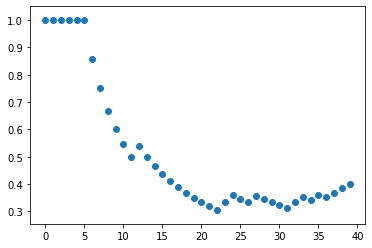

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(104, 55)
2022-02-22 12:45:00
2022-02-28 12:30:00
(39, 15)
2022-02-28 12:45:00
2022-03-01 15:45:00
% Model match:  0.4358974358974359


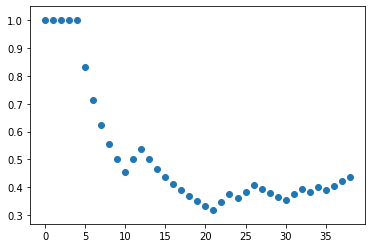

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(104, 55)
2022-02-22 13:00:00
2022-02-28 12:45:00
(38, 15)
2022-02-28 13:00:00
2022-03-01 15:45:00
% Model match:  0.3157894736842105


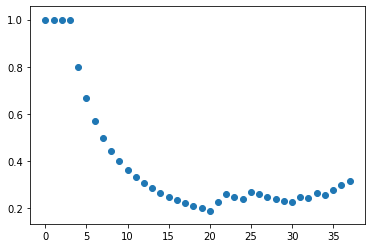

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(104, 55)
2022-02-22 13:15:00
2022-02-28 13:00:00
(37, 15)
2022-02-28 13:15:00
2022-03-01 15:45:00
% Model match:  0.43243243243243246


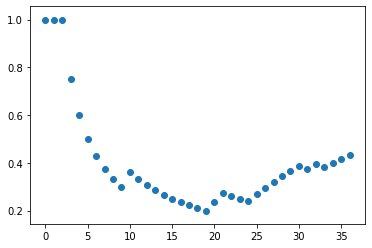

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(104, 55)
2022-02-22 13:30:00
2022-02-28 13:15:00
(36, 15)
2022-02-28 13:30:00
2022-03-01 15:45:00
% Model match:  0.4166666666666667


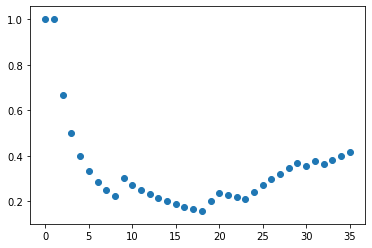

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(104, 55)
2022-02-22 13:45:00
2022-02-28 13:30:00
(35, 15)
2022-02-28 13:45:00
2022-03-01 15:45:00
% Model match:  0.4


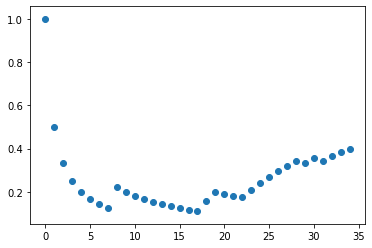

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(104, 55)
2022-02-22 14:00:00
2022-02-28 13:45:00
(34, 15)
2022-02-28 14:00:00
2022-03-01 15:45:00
% Model match:  0.29411764705882354


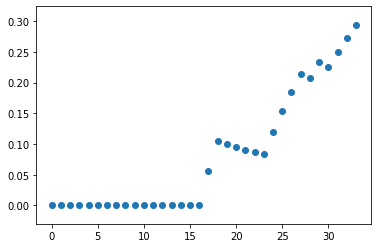

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(104, 55)
2022-02-22 14:15:00
2022-02-28 14:00:00
(33, 15)
2022-02-28 14:15:00
2022-03-01 15:45:00
% Model match:  0.42424242424242425


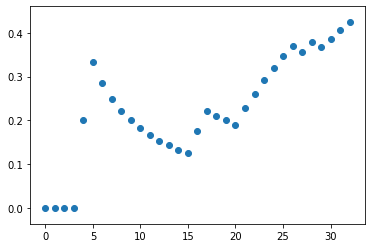

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(104, 55)
2022-02-22 14:30:00
2022-02-28 14:15:00
(32, 15)
2022-02-28 14:30:00
2022-03-01 15:45:00
% Model match:  0.53125


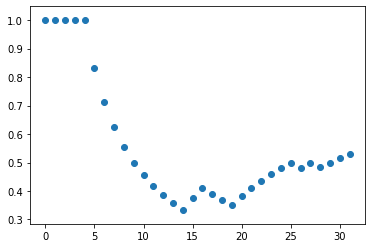

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(104, 55)
2022-02-22 14:45:00
2022-02-28 14:30:00
(31, 15)
2022-02-28 14:45:00
2022-03-01 15:45:00
% Model match:  0.45161290322580644


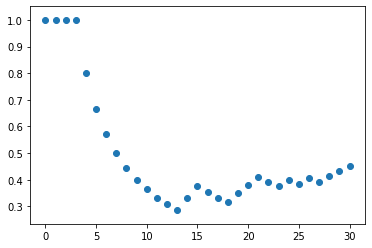

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(104, 55)
2022-02-22 15:00:00
2022-02-28 14:45:00
(30, 15)
2022-02-28 15:00:00
2022-03-01 15:45:00
% Model match:  0.5


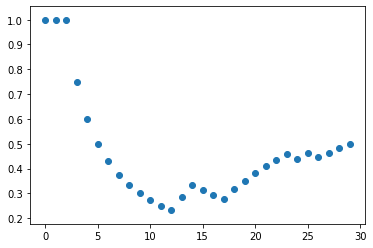

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(104, 55)
2022-02-22 15:15:00
2022-02-28 15:00:00
(29, 15)
2022-02-28 15:15:00
2022-03-01 15:45:00
% Model match:  0.4827586206896552


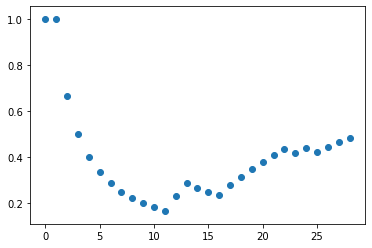

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(104, 55)
2022-02-22 15:30:00
2022-02-28 15:15:00
(28, 15)
2022-02-28 15:30:00
2022-03-01 15:45:00
% Model match:  0.4642857142857143


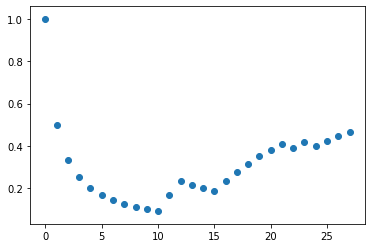

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(104, 55)
2022-02-22 15:45:00
2022-02-28 15:30:00
(27, 15)
2022-02-28 15:45:00
2022-03-01 15:45:00
% Model match:  0.4444444444444444


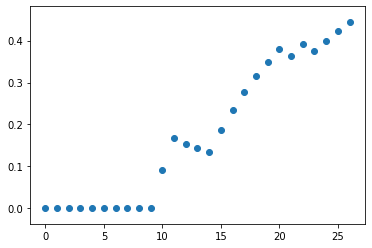

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(104, 55)
2022-02-23 09:45:00
2022-03-01 09:30:00
(51, 15)
2022-03-01 09:45:00
2022-03-02 15:45:00
% Model match:  0.6666666666666666


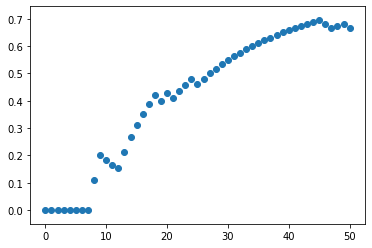

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(104, 55)
2022-02-23 10:00:00
2022-03-01 09:45:00
(50, 15)
2022-03-01 10:00:00
2022-03-02 15:45:00
% Model match:  0.62


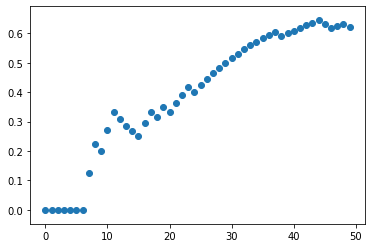

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(104, 55)
2022-02-23 10:15:00
2022-03-01 10:00:00
(49, 15)
2022-03-01 10:15:00
2022-03-02 15:45:00
% Model match:  0.6938775510204082


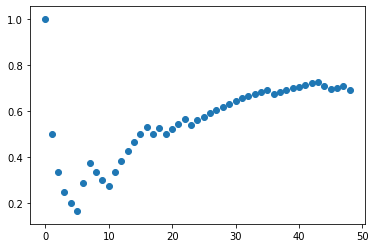

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(104, 55)
2022-02-23 10:30:00
2022-03-01 10:15:00
(48, 15)
2022-03-01 10:30:00
2022-03-02 15:45:00
% Model match:  0.7083333333333334


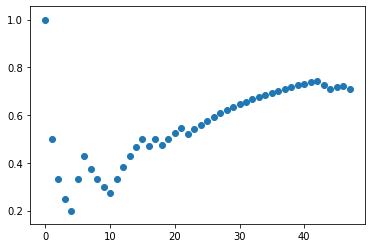

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6862745098039216
(104, 55)
2022-02-23 10:45:00
2022-03-01 10:30:00
(47, 15)
2022-03-01 10:45:00
2022-03-02 15:45:00
% Model match:  0.6595744680851063


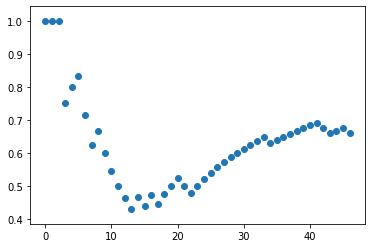

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6862745098039216
(104, 55)
2022-02-23 11:00:00
2022-03-01 10:45:00
(46, 15)
2022-03-01 11:00:00
2022-03-02 15:45:00
% Model match:  0.6739130434782609


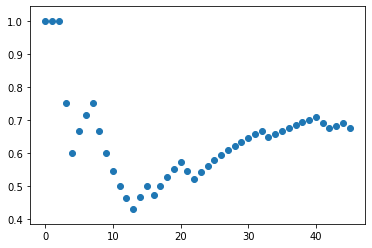

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6862745098039216
(104, 55)
2022-02-23 11:15:00
2022-03-01 11:00:00
(45, 15)
2022-03-01 11:15:00
2022-03-02 15:45:00
% Model match:  0.6222222222222222


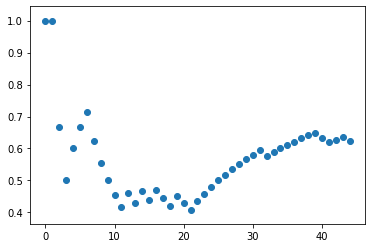

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7058823529411765
(104, 55)
2022-02-23 11:30:00
2022-03-01 11:15:00
(44, 15)
2022-03-01 11:30:00
2022-03-02 15:45:00
% Model match:  0.6818181818181818


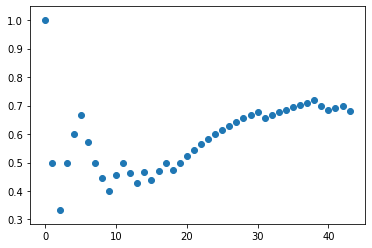

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6862745098039216
(104, 55)
2022-02-23 11:45:00
2022-03-01 11:30:00
(43, 15)
2022-03-01 11:45:00
2022-03-02 15:45:00
% Model match:  0.5813953488372093


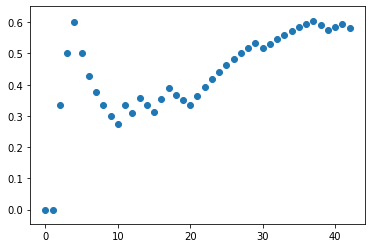

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7058823529411765
(104, 55)
2022-02-23 12:00:00
2022-03-01 11:45:00
(42, 15)
2022-03-01 12:00:00
2022-03-02 15:45:00
% Model match:  0.5952380952380952


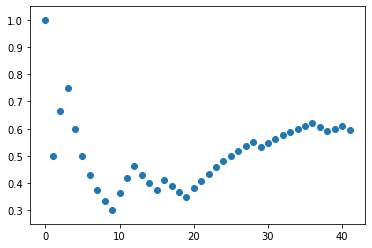

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(104, 55)
2022-02-23 12:15:00
2022-03-01 12:00:00
(41, 15)
2022-03-01 12:15:00
2022-03-02 15:45:00
% Model match:  0.6585365853658537


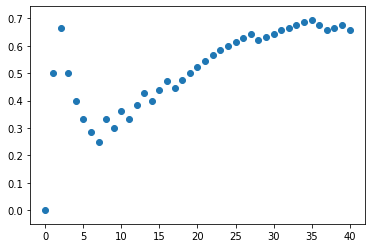

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7156862745098039
(104, 55)
2022-02-23 12:30:00
2022-03-01 12:15:00
(40, 15)
2022-03-01 12:30:00
2022-03-02 15:45:00
% Model match:  0.65


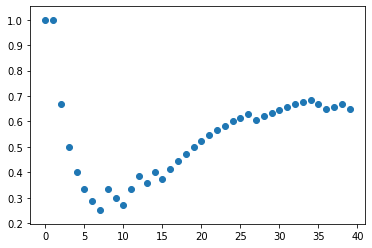

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(104, 55)
2022-02-23 12:45:00
2022-03-01 12:30:00
(39, 15)
2022-03-01 12:45:00
2022-03-02 15:45:00
% Model match:  0.5641025641025641


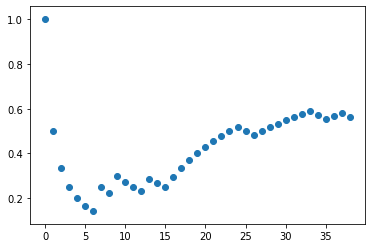

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7254901960784313
(104, 55)
2022-02-23 13:00:00
2022-03-01 12:45:00
(38, 15)
2022-03-01 13:00:00
2022-03-02 15:45:00
% Model match:  0.6052631578947368


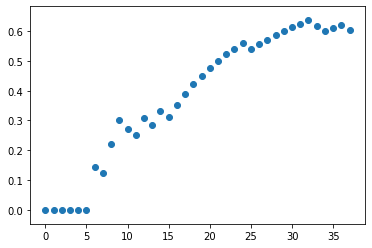

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(104, 55)
2022-02-23 13:15:00
2022-03-01 13:00:00
(37, 15)
2022-03-01 13:15:00
2022-03-02 15:45:00
% Model match:  0.7297297297297297


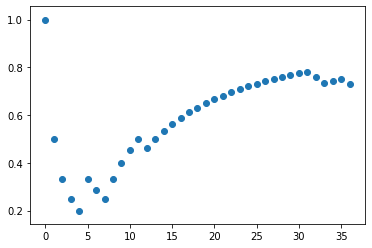

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(104, 55)
2022-02-23 13:30:00
2022-03-01 13:15:00
(36, 15)
2022-03-01 13:30:00
2022-03-02 15:45:00
% Model match:  0.7222222222222222


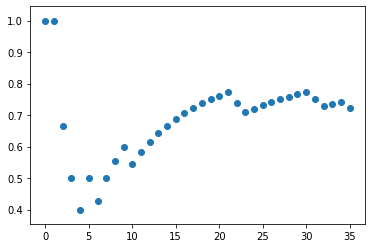

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(104, 55)
2022-02-23 13:45:00
2022-03-01 13:30:00
(35, 15)
2022-03-01 13:45:00
2022-03-02 15:45:00
% Model match:  0.7428571428571429


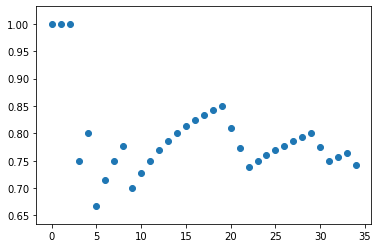

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(104, 55)
2022-02-23 14:00:00
2022-03-01 13:45:00
(34, 15)
2022-03-01 14:00:00
2022-03-02 15:45:00
% Model match:  0.8235294117647058


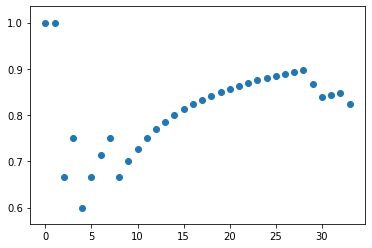

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(104, 55)
2022-02-23 14:15:00
2022-03-01 14:00:00
(33, 15)
2022-03-01 14:15:00
2022-03-02 15:45:00
% Model match:  0.8181818181818182


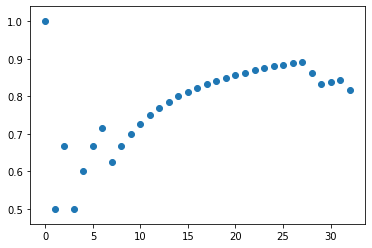

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(104, 55)
2022-02-23 14:30:00
2022-03-01 14:15:00
(32, 15)
2022-03-01 14:30:00
2022-03-02 15:45:00
% Model match:  0.75


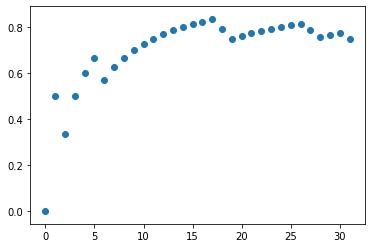

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(104, 55)
2022-02-23 14:45:00
2022-03-01 14:30:00
(31, 15)
2022-03-01 14:45:00
2022-03-02 15:45:00
% Model match:  0.7741935483870968


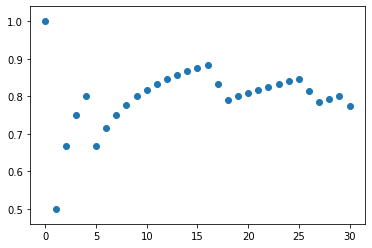

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(104, 55)
2022-02-23 15:00:00
2022-03-01 14:45:00
(30, 15)
2022-03-01 15:00:00
2022-03-02 15:45:00
% Model match:  0.7666666666666667


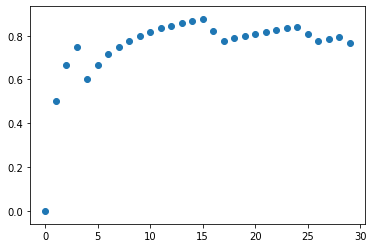

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5882352941176471
(104, 55)
2022-02-23 15:15:00
2022-03-01 15:00:00
(29, 15)
2022-03-01 15:15:00
2022-03-02 15:45:00
% Model match:  0.7931034482758621


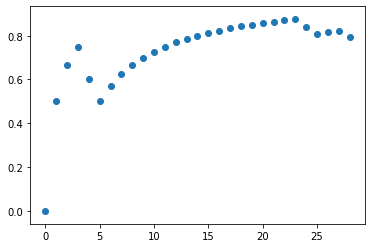

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(104, 55)
2022-02-23 15:30:00
2022-03-01 15:15:00
(28, 15)
2022-03-01 15:30:00
2022-03-02 15:45:00
% Model match:  0.8214285714285714


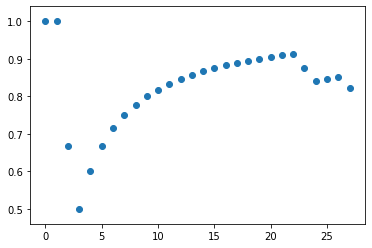

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5784313725490197
(104, 55)
2022-02-23 15:45:00
2022-03-01 15:30:00
(27, 15)
2022-03-01 15:45:00
2022-03-02 15:45:00
% Model match:  0.8518518518518519


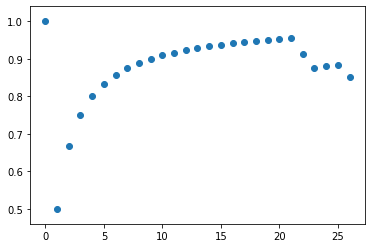

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(104, 55)
2022-02-24 09:45:00
2022-03-02 09:30:00
(51, 15)
2022-03-02 09:45:00
2022-03-03 15:45:00
% Model match:  0.5490196078431373


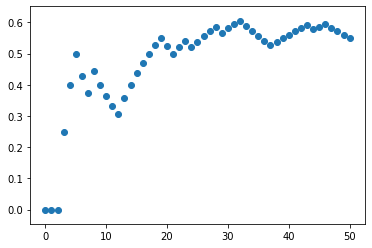

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(104, 55)
2022-02-24 10:00:00
2022-03-02 09:45:00
(50, 15)
2022-03-02 10:00:00
2022-03-03 15:45:00
% Model match:  0.64


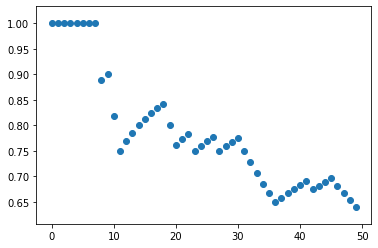

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5784313725490197
(104, 55)
2022-02-24 10:15:00
2022-03-02 10:00:00
(49, 15)
2022-03-02 10:15:00
2022-03-03 15:45:00
% Model match:  0.6530612244897959


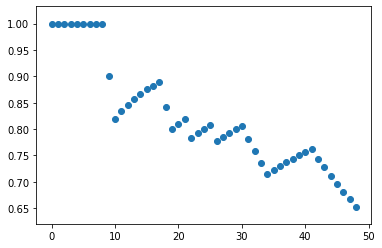

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(104, 55)
2022-02-24 10:30:00
2022-03-02 10:15:00
(48, 15)
2022-03-02 10:30:00
2022-03-03 15:45:00
% Model match:  0.6458333333333334


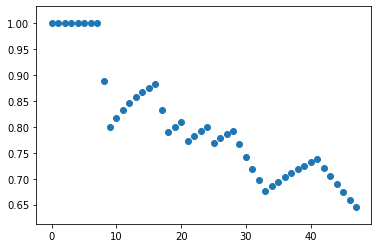

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(104, 55)
2022-02-24 10:45:00
2022-03-02 10:30:00
(47, 15)
2022-03-02 10:45:00
2022-03-03 15:45:00
% Model match:  0.6382978723404256


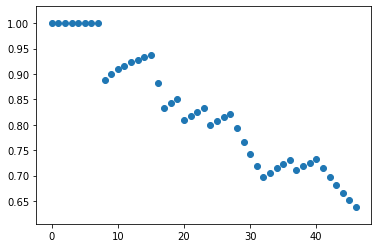

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(104, 55)
2022-02-24 11:00:00
2022-03-02 10:45:00
(46, 15)
2022-03-02 11:00:00
2022-03-03 15:45:00
% Model match:  0.6304347826086957


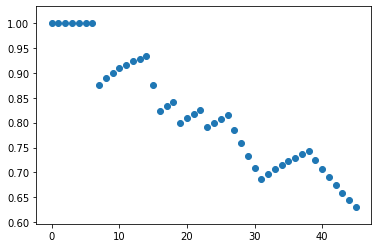

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(104, 55)
2022-02-24 11:15:00
2022-03-02 11:00:00
(45, 15)
2022-03-02 11:15:00
2022-03-03 15:45:00
% Model match:  0.6666666666666666


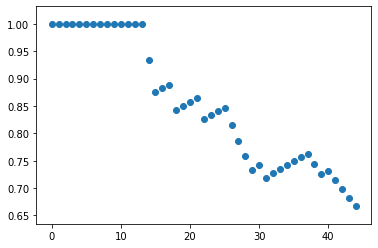

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(104, 55)
2022-02-24 11:30:00
2022-03-02 11:15:00
(44, 15)
2022-03-02 11:30:00
2022-03-03 15:45:00
% Model match:  0.7045454545454546


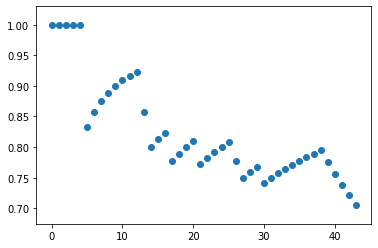

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5980392156862745
(104, 55)
2022-02-24 11:45:00
2022-03-02 11:30:00
(43, 15)
2022-03-02 11:45:00
2022-03-03 15:45:00
% Model match:  0.627906976744186


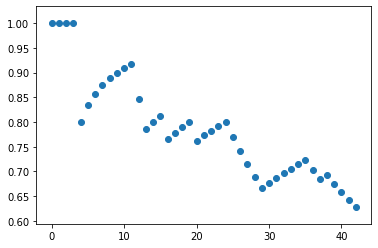

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(104, 55)
2022-02-24 12:00:00
2022-03-02 11:45:00
(42, 15)
2022-03-02 12:00:00
2022-03-03 15:45:00
% Model match:  0.7142857142857143


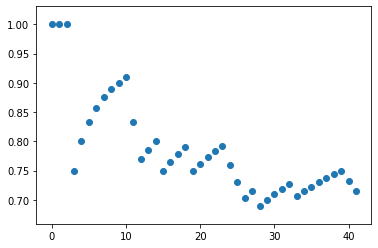

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5882352941176471
(104, 55)
2022-02-24 12:15:00
2022-03-02 12:00:00
(41, 15)
2022-03-02 12:15:00
2022-03-03 15:45:00
% Model match:  0.6341463414634146


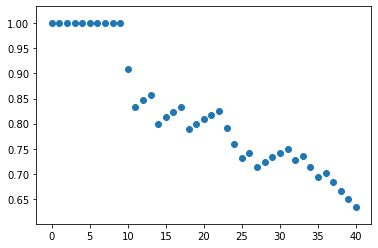

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(104, 55)
2022-02-24 12:30:00
2022-03-02 12:15:00
(40, 15)
2022-03-02 12:30:00
2022-03-03 15:45:00
% Model match:  0.7


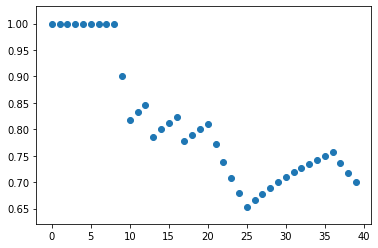

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(104, 55)
2022-02-24 12:45:00
2022-03-02 12:30:00
(39, 15)
2022-03-02 12:45:00
2022-03-03 15:45:00
% Model match:  0.5384615384615384


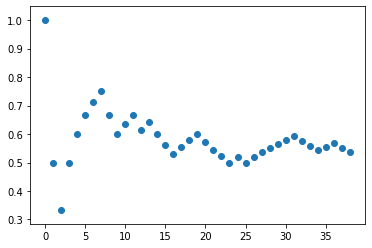

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6764705882352942
(104, 55)
2022-02-24 13:00:00
2022-03-02 12:45:00
(38, 15)
2022-03-02 13:00:00
2022-03-03 15:45:00
% Model match:  0.6052631578947368


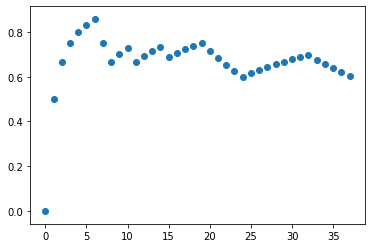

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5784313725490197
(104, 55)
2022-02-24 13:15:00
2022-03-02 13:00:00
(37, 15)
2022-03-02 13:15:00
2022-03-03 15:45:00
% Model match:  0.6756756756756757


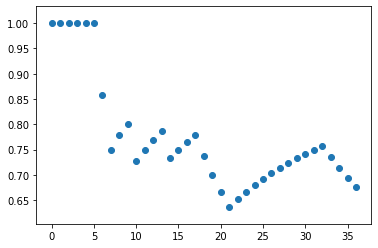

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(104, 55)
2022-02-24 13:30:00
2022-03-02 13:15:00
(36, 15)
2022-03-02 13:30:00
2022-03-03 15:45:00
% Model match:  0.6111111111111112


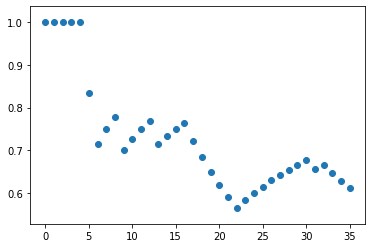

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5882352941176471
(104, 55)
2022-02-24 13:45:00
2022-03-02 13:30:00
(35, 15)
2022-03-02 13:45:00
2022-03-03 15:45:00
% Model match:  0.6285714285714286


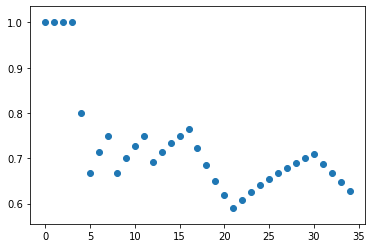

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(104, 55)
2022-02-24 14:00:00
2022-03-02 13:45:00
(34, 15)
2022-03-02 14:00:00
2022-03-03 15:45:00
% Model match:  0.5882352941176471


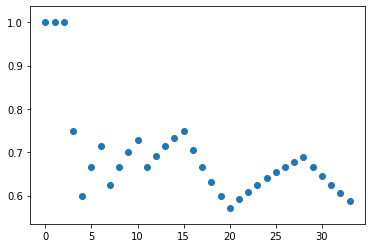

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(104, 55)
2022-02-24 14:15:00
2022-03-02 14:00:00
(33, 15)
2022-03-02 14:15:00
2022-03-03 15:45:00
% Model match:  0.6060606060606061


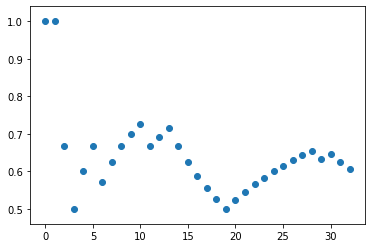

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(104, 55)
2022-02-24 14:30:00
2022-03-02 14:15:00
(32, 15)
2022-03-02 14:30:00
2022-03-03 15:45:00
% Model match:  0.625


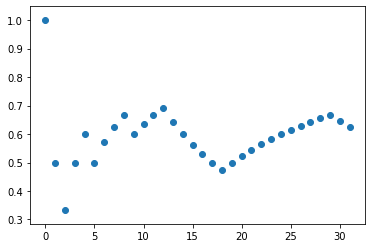

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5882352941176471
(104, 55)
2022-02-24 14:45:00
2022-03-02 14:30:00
(31, 15)
2022-03-02 14:45:00
2022-03-03 15:45:00
% Model match:  0.5806451612903226


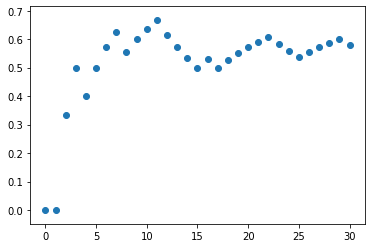

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(104, 55)
2022-02-24 15:00:00
2022-03-02 14:45:00
(30, 15)
2022-03-02 15:00:00
2022-03-03 15:45:00
% Model match:  0.6


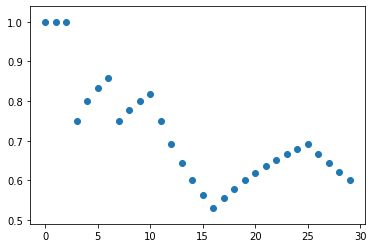

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(104, 55)
2022-02-24 15:15:00
2022-03-02 15:00:00
(29, 15)
2022-03-02 15:15:00
2022-03-03 15:45:00
% Model match:  0.5517241379310345


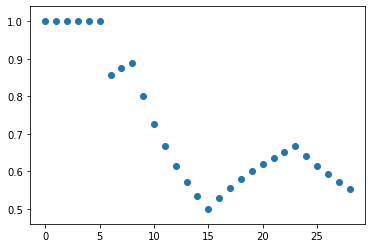

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6764705882352942
(104, 55)
2022-02-24 15:30:00
2022-03-02 15:15:00
(28, 15)
2022-03-02 15:30:00
2022-03-03 15:45:00
% Model match:  0.5357142857142857


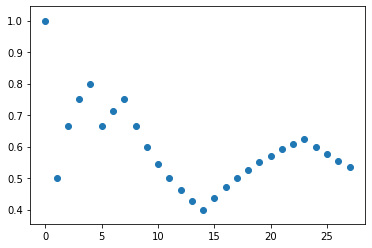

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(104, 55)
2022-02-24 15:45:00
2022-03-02 15:30:00
(27, 15)
2022-03-02 15:45:00
2022-03-03 15:45:00
% Model match:  0.5185185185185185


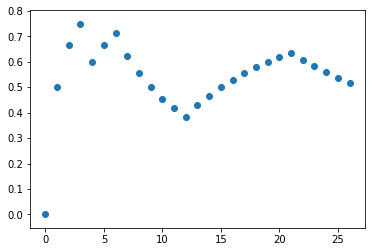

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5882352941176471
(104, 55)
2022-02-25 09:45:00
2022-03-03 09:30:00
(51, 15)
2022-03-03 09:45:00
2022-03-04 15:45:00
% Model match:  0.5686274509803921


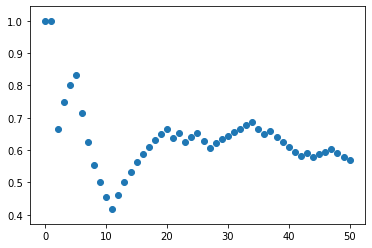

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6764705882352942
(104, 55)
2022-02-25 10:00:00
2022-03-03 09:45:00
(50, 15)
2022-03-03 10:00:00
2022-03-04 15:45:00
% Model match:  0.52


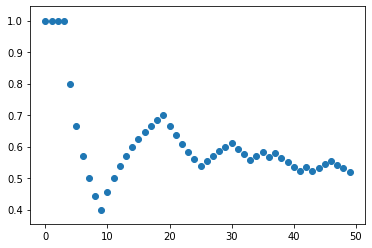

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5882352941176471
(104, 55)
2022-02-25 10:15:00
2022-03-03 10:00:00
(49, 15)
2022-03-03 10:15:00
2022-03-04 15:45:00
% Model match:  0.5714285714285714


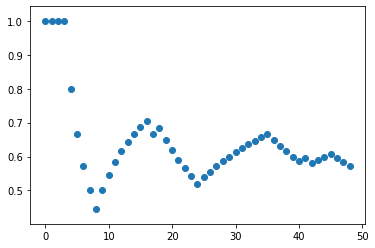

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(104, 55)
2022-02-25 10:30:00
2022-03-03 10:15:00
(48, 15)
2022-03-03 10:30:00
2022-03-04 15:45:00
% Model match:  0.4583333333333333


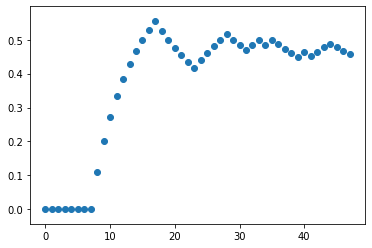

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5784313725490197
(104, 55)
2022-02-25 10:45:00
2022-03-03 10:30:00
(47, 15)
2022-03-03 10:45:00
2022-03-04 15:45:00
% Model match:  0.48936170212765956


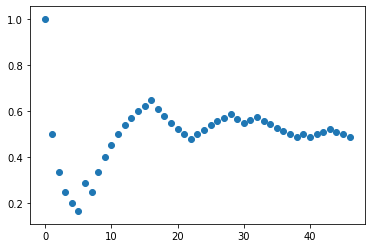

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(104, 55)
2022-02-25 11:00:00
2022-03-03 10:45:00
(46, 15)
2022-03-03 11:00:00
2022-03-04 15:45:00
% Model match:  0.5


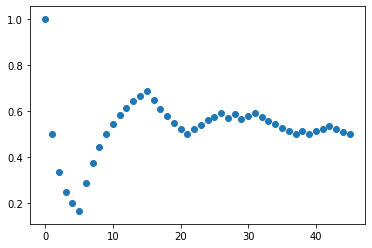

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5490196078431373
(104, 55)
2022-02-25 11:15:00
2022-03-03 11:00:00
(45, 15)
2022-03-03 11:15:00
2022-03-04 15:45:00
% Model match:  0.5777777777777777


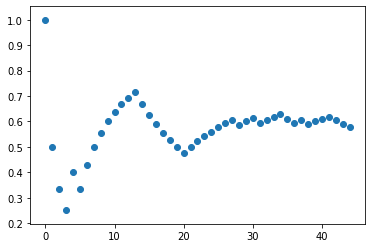

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(104, 55)
2022-02-25 11:30:00
2022-03-03 11:15:00
(44, 15)
2022-03-03 11:30:00
2022-03-04 15:45:00
% Model match:  0.4772727272727273


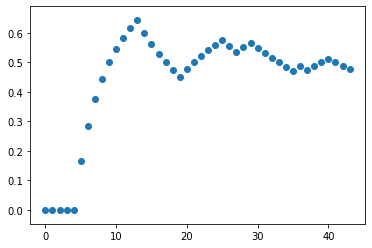

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5686274509803921
(104, 55)
2022-02-25 11:45:00
2022-03-03 11:30:00
(43, 15)
2022-03-03 11:45:00
2022-03-04 15:45:00
% Model match:  0.5348837209302325


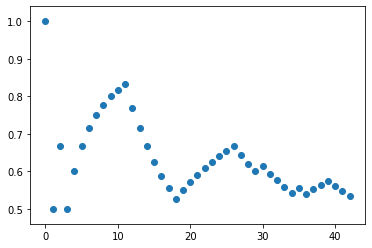

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(104, 55)
2022-02-25 12:00:00
2022-03-03 11:45:00
(42, 15)
2022-03-03 12:00:00
2022-03-04 15:45:00
% Model match:  0.6190476190476191


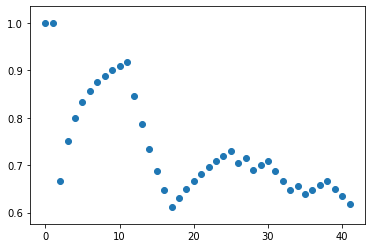

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5294117647058824
(104, 55)
2022-02-25 12:15:00
2022-03-03 12:00:00
(41, 15)
2022-03-03 12:15:00
2022-03-04 15:45:00
% Model match:  0.5853658536585366


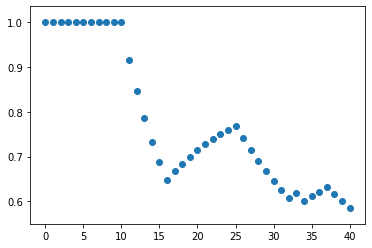

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(104, 55)
2022-02-25 12:30:00
2022-03-03 12:15:00
(40, 15)
2022-03-03 12:30:00
2022-03-04 15:45:00
% Model match:  0.575


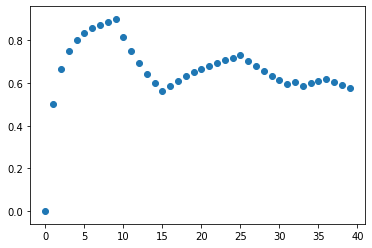

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5294117647058824
(104, 55)
2022-02-25 12:45:00
2022-03-03 12:30:00
(39, 15)
2022-03-03 12:45:00
2022-03-04 15:45:00
% Model match:  0.5384615384615384


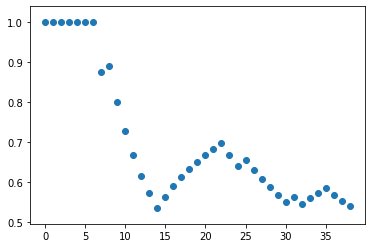

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5882352941176471
(104, 55)
2022-02-25 13:00:00
2022-03-03 12:45:00
(38, 15)
2022-03-03 13:00:00
2022-03-04 15:45:00
% Model match:  0.5789473684210527


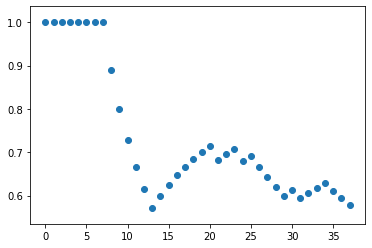

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5392156862745098
(104, 55)
2022-02-25 13:15:00
2022-03-03 13:00:00
(37, 15)
2022-03-03 13:15:00
2022-03-04 15:45:00
% Model match:  0.5675675675675675


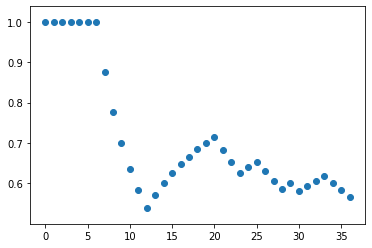

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(104, 55)
2022-02-25 13:30:00
2022-03-03 13:15:00
(36, 15)
2022-03-03 13:30:00
2022-03-04 15:45:00
% Model match:  0.6111111111111112


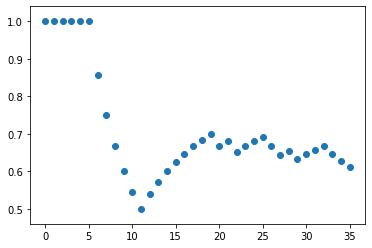

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5588235294117647
(104, 55)
2022-02-25 13:45:00
2022-03-03 13:30:00
(35, 15)
2022-03-03 13:45:00
2022-03-04 15:45:00
% Model match:  0.5428571428571428


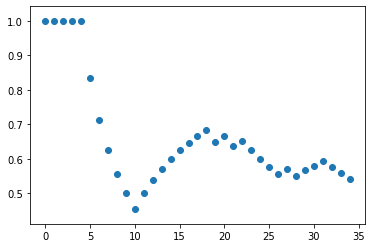

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(104, 55)
2022-02-25 14:00:00
2022-03-03 13:45:00
(34, 15)
2022-03-03 14:00:00
2022-03-04 15:45:00
% Model match:  0.6470588235294118


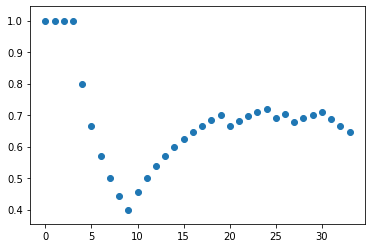

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5392156862745098
(104, 55)
2022-02-25 14:15:00
2022-03-03 14:00:00
(33, 15)
2022-03-03 14:15:00
2022-03-04 15:45:00
% Model match:  0.6363636363636364


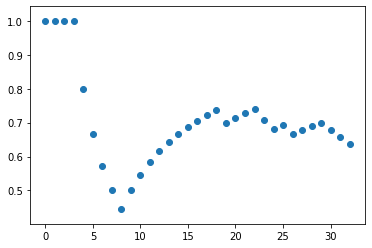

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(104, 55)
2022-02-25 14:30:00
2022-03-03 14:15:00
(32, 15)
2022-03-03 14:30:00
2022-03-04 15:45:00
% Model match:  0.65625


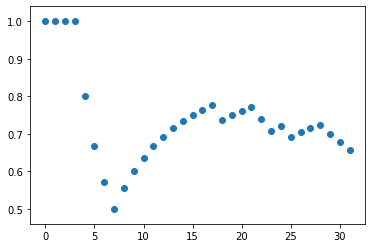

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5784313725490197
(104, 55)
2022-02-25 14:45:00
2022-03-03 14:30:00
(31, 15)
2022-03-03 14:45:00
2022-03-04 15:45:00
% Model match:  0.5161290322580645


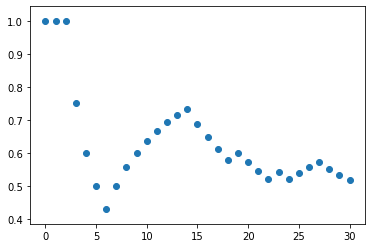

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5882352941176471
(104, 55)
2022-02-25 15:00:00
2022-03-03 14:45:00
(30, 15)
2022-03-03 15:00:00
2022-03-04 15:45:00
% Model match:  0.5666666666666667


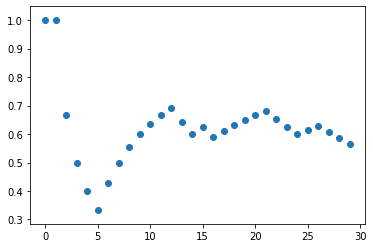

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5196078431372549
(104, 55)
2022-02-25 15:15:00
2022-03-03 15:00:00
(29, 15)
2022-03-03 15:15:00
2022-03-04 15:45:00
% Model match:  0.5517241379310345


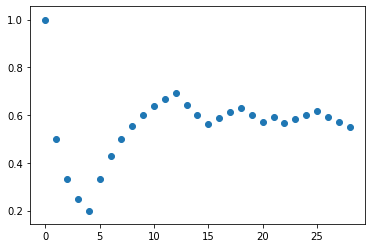

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(104, 55)
2022-02-25 15:30:00
2022-03-03 15:15:00
(28, 15)
2022-03-03 15:30:00
2022-03-04 15:45:00
% Model match:  0.6428571428571429


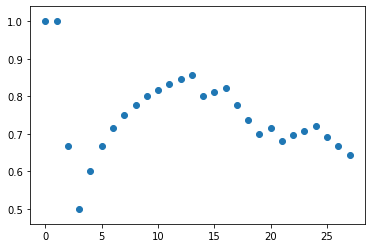

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5784313725490197
(104, 55)
2022-02-25 15:45:00
2022-03-03 15:30:00
(27, 15)
2022-03-03 15:45:00
2022-03-04 15:45:00
% Model match:  0.5555555555555556


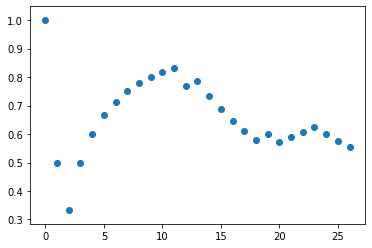

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5686274509803921
(105, 55)
2022-02-28 09:30:00
2022-03-04 09:30:00
(25, 15)
2022-03-04 09:45:00
2022-03-04 15:45:00
% Model match:  0.64


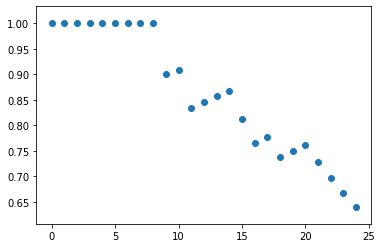

Number of splits for CV:  52
Fitting 52 folds for each of 1 candidates, totalling 52 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5865384615384616
(106, 55)
2022-02-28 09:30:00
2022-03-04 09:45:00
(24, 15)
2022-03-04 10:00:00
2022-03-04 15:45:00
% Model match:  0.5416666666666666


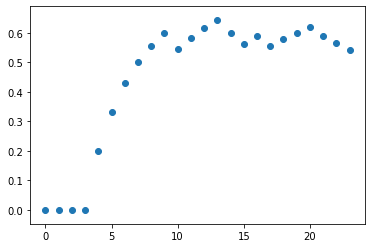

Number of splits for CV:  53
Fitting 53 folds for each of 1 candidates, totalling 53 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6226415094339622
(107, 55)
2022-02-28 09:30:00
2022-03-04 10:00:00
(23, 15)
2022-03-04 10:15:00
2022-03-04 15:45:00
% Model match:  0.5217391304347826


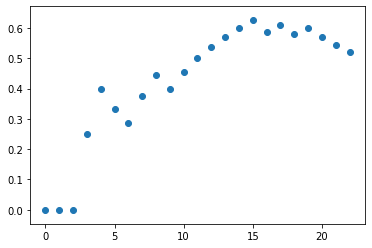

Number of splits for CV:  53
Fitting 53 folds for each of 1 candidates, totalling 53 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5754716981132075
(108, 55)
2022-02-28 09:30:00
2022-03-04 10:15:00
(22, 15)
2022-03-04 10:30:00
2022-03-04 15:45:00
% Model match:  0.5909090909090909


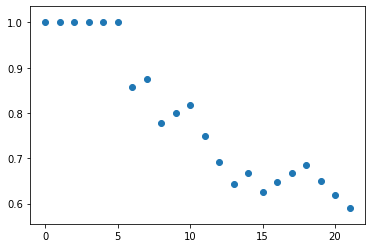

Number of splits for CV:  53
Fitting 53 folds for each of 1 candidates, totalling 53 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5566037735849056
(109, 55)
2022-02-28 09:30:00
2022-03-04 10:30:00
(21, 15)
2022-03-04 10:45:00
2022-03-04 15:45:00
% Model match:  0.5238095238095238


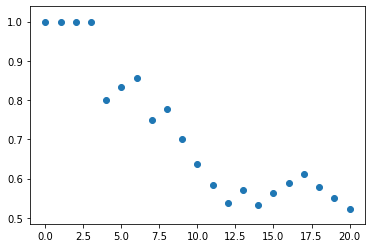

Number of splits for CV:  54
Fitting 54 folds for each of 1 candidates, totalling 54 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5648148148148148
(110, 55)
2022-02-28 09:30:00
2022-03-04 10:45:00
(20, 15)
2022-03-04 11:00:00
2022-03-04 15:45:00
% Model match:  0.5


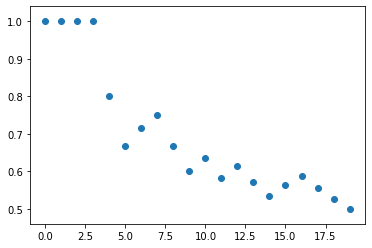

Number of splits for CV:  55
Fitting 55 folds for each of 1 candidates, totalling 55 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6181818181818182
(111, 55)
2022-02-28 09:30:00
2022-03-04 11:00:00
(19, 15)
2022-03-04 11:15:00
2022-03-04 15:45:00
% Model match:  0.3684210526315789


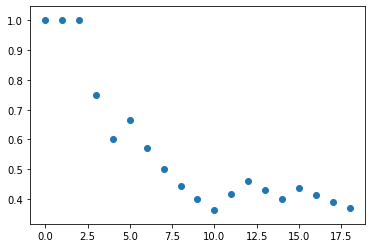

Number of splits for CV:  55
Fitting 55 folds for each of 1 candidates, totalling 55 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5727272727272728
(112, 55)
2022-02-28 09:30:00
2022-03-04 11:15:00
(18, 15)
2022-03-04 11:30:00
2022-03-04 15:45:00
% Model match:  0.5555555555555556


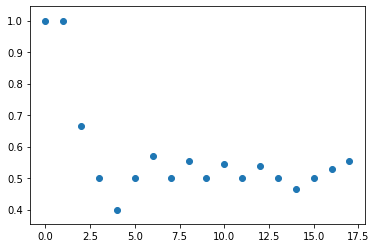

Number of splits for CV:  55
Fitting 55 folds for each of 1 candidates, totalling 55 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5727272727272728
(113, 55)
2022-02-28 09:30:00
2022-03-04 11:30:00
(17, 15)
2022-03-04 11:45:00
2022-03-04 15:45:00
% Model match:  0.5294117647058824


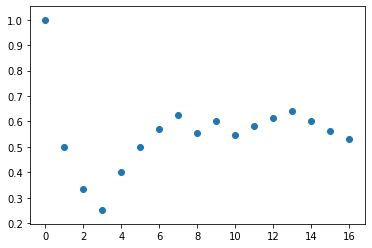

Number of splits for CV:  56
Fitting 56 folds for each of 1 candidates, totalling 56 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5803571428571429
(114, 55)
2022-02-28 09:30:00
2022-03-04 11:45:00
(16, 15)
2022-03-04 12:00:00
2022-03-04 15:45:00
% Model match:  0.375


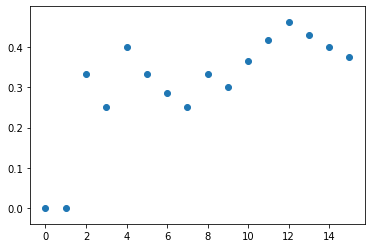

Number of splits for CV:  57
Fitting 57 folds for each of 1 candidates, totalling 57 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6140350877192983
(115, 55)
2022-02-28 09:30:00
2022-03-04 12:00:00
(15, 15)
2022-03-04 12:15:00
2022-03-04 15:45:00
% Model match:  0.5333333333333333


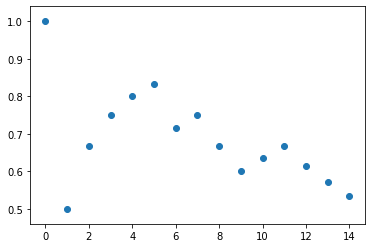

Number of splits for CV:  57
Fitting 57 folds for each of 1 candidates, totalling 57 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5701754385964912
(116, 55)
2022-02-28 09:30:00
2022-03-04 12:15:00
(14, 15)
2022-03-04 12:30:00
2022-03-04 15:45:00
% Model match:  0.6428571428571429


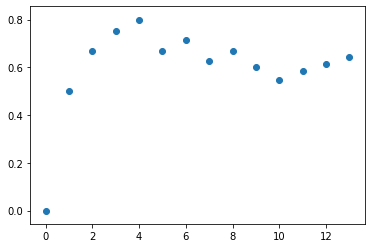

Number of splits for CV:  57
Fitting 57 folds for each of 1 candidates, totalling 57 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5701754385964912
(117, 55)
2022-02-28 09:30:00
2022-03-04 12:30:00
(13, 15)
2022-03-04 12:45:00
2022-03-04 15:45:00
% Model match:  0.23076923076923078


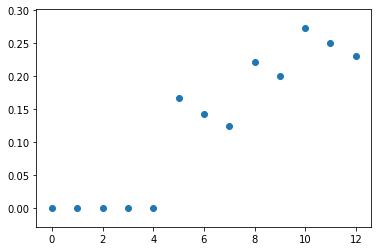

Number of splits for CV:  58
Fitting 58 folds for each of 1 candidates, totalling 58 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5689655172413793
(118, 55)
2022-02-28 09:30:00
2022-03-04 12:45:00
(12, 15)
2022-03-04 13:00:00
2022-03-04 15:45:00
% Model match:  0.5


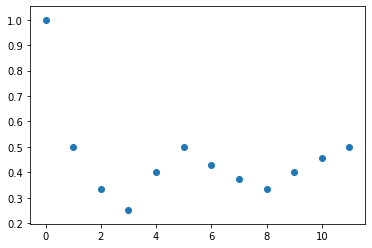

Number of splits for CV:  59
Fitting 59 folds for each of 1 candidates, totalling 59 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6101694915254238
(119, 55)
2022-02-28 09:30:00
2022-03-04 13:00:00
(11, 15)
2022-03-04 13:15:00
2022-03-04 15:45:00
% Model match:  0.8181818181818182


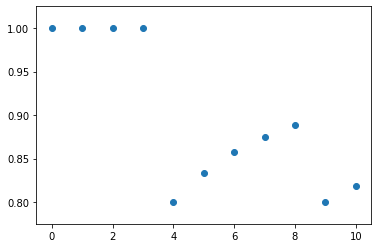

Number of splits for CV:  59
Fitting 59 folds for each of 1 candidates, totalling 59 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.559322033898305
(120, 55)
2022-02-28 09:30:00
2022-03-04 13:15:00
(10, 15)
2022-03-04 13:30:00
2022-03-04 15:45:00
% Model match:  0.8


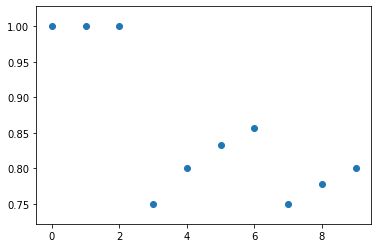

Number of splits for CV:  59
Fitting 59 folds for each of 1 candidates, totalling 59 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.559322033898305
(121, 55)
2022-02-28 09:30:00
2022-03-04 13:30:00
(9, 15)
2022-03-04 13:45:00
2022-03-04 15:45:00
% Model match:  0.5555555555555556


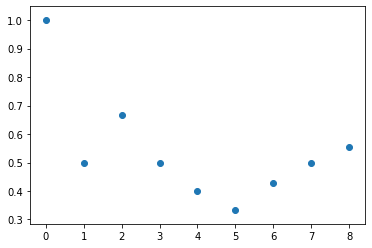

Number of splits for CV:  60
Fitting 60 folds for each of 1 candidates, totalling 60 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.55
(122, 55)
2022-02-28 09:30:00
2022-03-04 13:45:00
(8, 15)
2022-03-04 14:00:00
2022-03-04 15:45:00
% Model match:  0.5


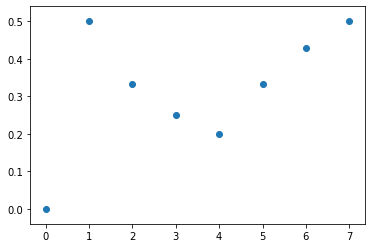

Number of splits for CV:  61
Fitting 61 folds for each of 1 candidates, totalling 61 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5901639344262295
(123, 55)
2022-02-28 09:30:00
2022-03-04 14:00:00
(7, 15)
2022-03-04 14:15:00
2022-03-04 15:45:00
% Model match:  0.14285714285714285


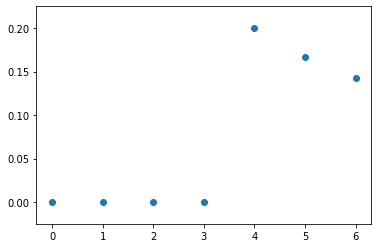

Number of splits for CV:  61
Fitting 61 folds for each of 1 candidates, totalling 61 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5491803278688525
(124, 55)
2022-02-28 09:30:00
2022-03-04 14:15:00
(6, 15)
2022-03-04 14:30:00
2022-03-04 15:45:00
% Model match:  0.3333333333333333


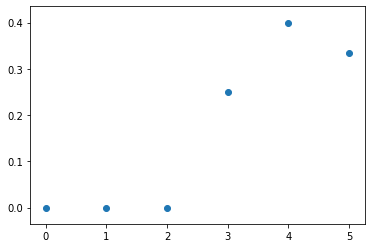

Number of splits for CV:  61
Fitting 61 folds for each of 1 candidates, totalling 61 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5409836065573771
(125, 55)
2022-02-28 09:30:00
2022-03-04 14:30:00
(5, 15)
2022-03-04 14:45:00
2022-03-04 15:45:00
% Model match:  0.4


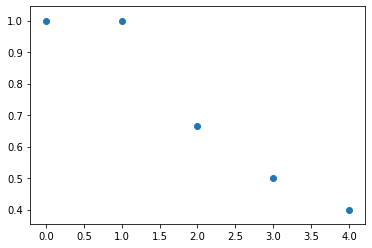

Number of splits for CV:  62
Fitting 62 folds for each of 1 candidates, totalling 62 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5403225806451613
(126, 55)
2022-02-28 09:30:00
2022-03-04 14:45:00
(4, 15)
2022-03-04 15:00:00
2022-03-04 15:45:00
% Model match:  0.25


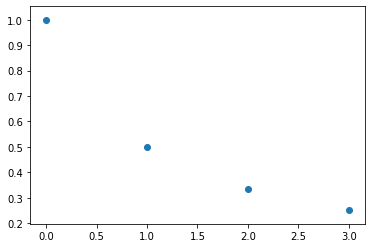

Number of splits for CV:  63
Fitting 63 folds for each of 1 candidates, totalling 63 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5873015873015873
(127, 55)
2022-02-28 09:30:00
2022-03-04 15:00:00
(3, 15)
2022-03-04 15:15:00
2022-03-04 15:45:00
% Model match:  0.0


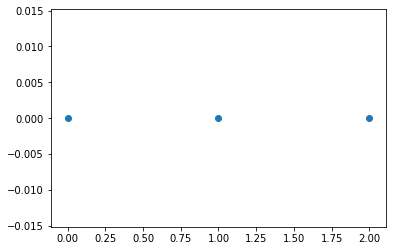

Number of splits for CV:  63
Fitting 63 folds for each of 1 candidates, totalling 63 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5396825396825397
(128, 55)
2022-02-28 09:30:00
2022-03-04 15:15:00
(2, 15)
2022-03-04 15:30:00
2022-03-04 15:45:00
% Model match:  1.0


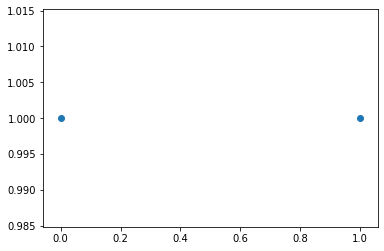

Number of splits for CV:  63
Fitting 63 folds for each of 1 candidates, totalling 63 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5396825396825397
(129, 55)
2022-02-28 09:30:00
2022-03-04 15:30:00
(1, 15)
2022-03-04 15:45:00
2022-03-04 15:45:00
% Model match:  1.0


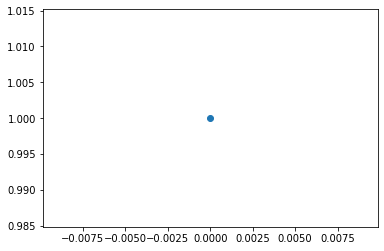

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5294117647058824
(104, 55)
2022-03-01 09:45:00
2022-03-07 09:30:00
(9, 15)
2022-03-07 09:45:00
2022-03-07 11:33:43
% Model match:  0.1111111111111111


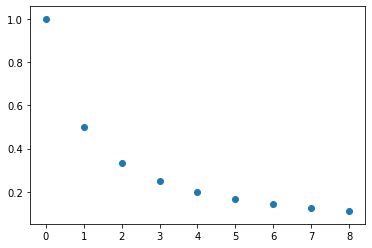

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5490196078431373
(104, 55)
2022-03-01 10:00:00
2022-03-07 09:45:00
(8, 15)
2022-03-07 10:00:00
2022-03-07 11:33:43
% Model match:  0.0


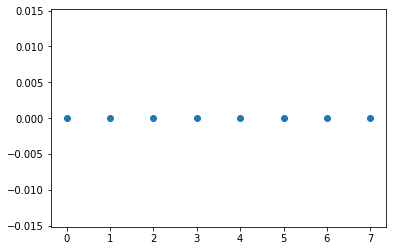

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5882352941176471
(103, 55)
2022-03-01 10:15:00
2022-03-07 09:45:00
(7, 15)
2022-03-07 10:15:00
2022-03-07 11:33:43
% Model match:  0.0


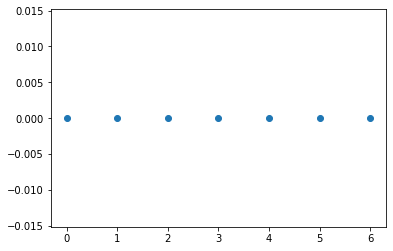

Number of splits for CV:  50
Fitting 50 folds for each of 1 candidates, totalling 50 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.51
(102, 55)
2022-03-01 10:30:00
2022-03-07 09:45:00
(6, 15)
2022-03-07 10:30:00
2022-03-07 11:33:43
% Model match:  0.0


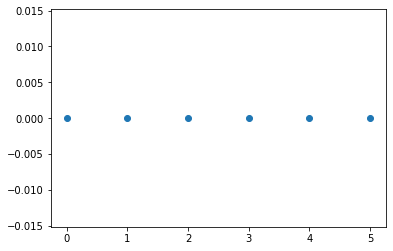

Number of splits for CV:  49
Fitting 49 folds for each of 1 candidates, totalling 49 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.47959183673469385
(101, 55)
2022-03-01 10:45:00
2022-03-07 09:45:00
(5, 15)
2022-03-07 10:45:00
2022-03-07 11:33:43
% Model match:  0.0


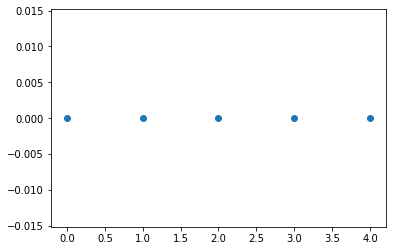

Number of splits for CV:  49
Fitting 49 folds for each of 1 candidates, totalling 49 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.45918367346938777
(100, 55)
2022-03-01 11:00:00
2022-03-07 09:45:00
(4, 15)
2022-03-07 11:00:00
2022-03-07 11:33:43
% Model match:  0.0


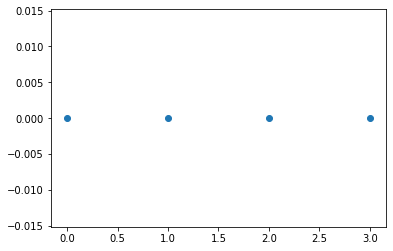

Number of splits for CV:  49
Fitting 49 folds for each of 1 candidates, totalling 49 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5102040816326531
(99, 55)
2022-03-01 11:15:00
2022-03-07 09:45:00
(3, 15)
2022-03-07 11:15:00
2022-03-07 11:33:43
% Model match:  0.0


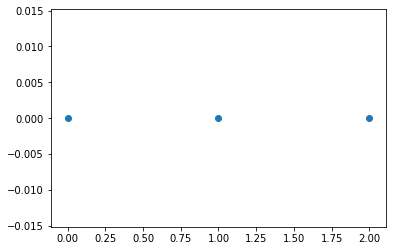

Number of splits for CV:  48
Fitting 48 folds for each of 1 candidates, totalling 48 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.4791666666666667
(98, 55)
2022-03-01 11:30:00
2022-03-07 09:45:00
(2, 15)
2022-03-07 11:30:00
2022-03-07 11:33:43
% Model match:  0.0


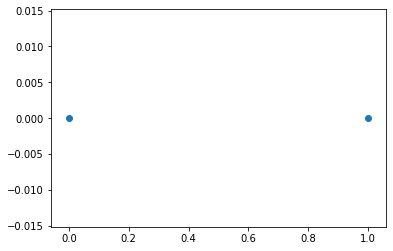

Number of splits for CV:  47
Fitting 47 folds for each of 1 candidates, totalling 47 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.425531914893617


ValueError: Found array with 0 sample(s) (shape=(0, 45)) while a minimum of 1 is required.

In [18]:

for dtime in testing_dates_01:
    #Defines the time window to do analisys
    order_datetime = dtime
    start_datetime = order_datetime - relativedelta(days=6)
    end_datetime = order_datetime + relativedelta(days=1.5)

    df_sim_results = simulation(order_datetime, start_datetime, end_datetime)
    
    if dtime == testing_dates_01[0]:
        df_sim_results_01 = df_sim_results.copy()
    else:
        df_sim_results_01 = df_sim_results_01.append(df_sim_results).copy()
        
    

In [19]:
#testing_dates
df_sim_results_01

Datetime        Close target_order  target_close  \
0  2022-02-16 09:45:00  4437.689941         BUY2   4471.569824   
1  2022-02-16 10:00:00  4439.830078         BUY2   4471.569824   
0  2022-02-16 10:00:00  4439.830078         BUY2   4471.569824   
1  2022-02-16 10:15:00  4442.410156         BUY2   4471.569824   
0  2022-02-16 10:15:00  4442.410156         BUY2   4471.569824   
..                 ...          ...          ...           ...   
1  2022-03-07 11:15:00  4269.169922         NULL           NaN   
0  2022-03-07 11:15:00  4269.169922         NULL           NaN   
1  2022-03-07 11:30:00  4262.000000         NULL           NaN   
0  2022-03-07 11:30:00  4262.000000         NULL           NaN   
1  2022-03-07 11:33:43  4259.500000         NULL           NaN   

    target_difference         target_date  target_date_diff  \
0                34.0 2022-02-16 14:15:00             270.0   
1                32.0 2022-02-16 14:15:00             255.0   
0                32.0 2022-02-16 14:15:00             255.0   
1                29.0 2022-02-16 14:15:00             240.0   
0                29.0 2022-02-16 14:15:00             240.0   
..                ...                 ...               ...   
1                 NaN                 NaT               NaN   
0                 NaN                 NaT               NaN   
1                 NaN                 NaT               NaN   
0                 NaN                 NaT               NaN   
1                 NaN                 NaT               NaN   

   target_order_coded y_pred prediction_order         0         1         2  \
0                  01     03            SELL2  0.220000  0.238808  0.149406   
1                  01     03            SELL2  0.200000  0.229146  0.135469   
0                  01     01             BUY2  0.010000  0.529201  0.062876   
1                  01     03            SELL2  0.010000  0.417885  0.141991   
0                  01     01             BUY2  0.000000  0.559323  0.049304   
..                ...    ...              ...       ...       ...       ...   
1                  02     00              BUY  0.652200  0.085598  0.151399   
0                  02     00              BUY  0.696165  0.071506  0.136524   
1                  02     00              BUY  0.670825  0.131000  0.108175   
0                  02     00              BUY  0.643002  0.161322  0.140778   
1                  02     00              BUY  0.643002  0.166998  0.135102   

           3  max_prob  Model match  
0   0.391786  0.391786     0.647059  
1   0.435384  0.435384     0.647059  
0   0.397923  0.529201     0.680000  
1   0.430124  0.430124     0.680000  
0   0.391373  0.559323     0.693878  
..       ...       ...          ...  
1   0.110803  0.652200     0.000000  
0   0.095804  0.696165     0.000000  
1   0.090000  0.670825     0.000000  
0   0.054898  0.643002     0.000000  
1   0.054898  0.643002     0.000000  

[613 rows x 16 columns]

In [20]:
df_sim_results_01 = df_sim_results_01.reset_index()

In [21]:
# Confusion Matrix

ls_model_matches = []

for i in range(1,len(df_sim_results_01)+1):
    #df_model_preds_01 = df_model_preds[df_model_preds['max_prob']>=0.42].copy()
    df_model_preds_01 = df_sim_results_01.iloc[:i,].copy()


    df_summary = df_model_preds_01.groupby(['target_order','prediction_order'] ).agg(
        orders_quantity = ('max_prob','count'),
        median_time = ('target_date_diff','median')
    )

    df_summary = df_summary.reset_index()

    True_buys = sum(df_summary[(df_summary['target_order'].isin(['BUY','BUY2']))&(df_summary['prediction_order'].isin(['BUY','BUY2']))]['orders_quantity'])
    True_sells = sum(df_summary[(df_summary['target_order'].isin(['SELL','SELL2']))&(df_summary['prediction_order'].isin(['SELL','SELL2']))]['orders_quantity'])
    Total_orders = sum(df_summary['orders_quantity'])

    pp_model_match = (True_buys + True_sells) / Total_orders
    ls_model_matches.append(pp_model_match)

print('% Model match: ', pp_model_match)
df_summary.sort_values(['orders_quantity'],ascending=[False])

% Model match:  0.7471451876019576


target_order prediction_order  orders_quantity  median_time
12         SELL             SELL              118         60.0
0           BUY              BUY              112         45.0
17        SELL2            SELL2              107       1155.0
2           BUY             SELL               40         67.5
16        SELL2             SELL               36       1125.0
5          BUY2             BUY2               28       1065.0
10         SELL              BUY               24         75.0
13         SELL            SELL2               21         45.0
4          BUY2              BUY               20        195.0
14        SELL2              BUY               20       1155.0
7          BUY2            SELL2               19        240.0
6          BUY2             SELL               18        150.0
1           BUY             BUY2               16         82.5
8          NULL              BUY               13          NaN
11         SELL             BUY2                8         45.0
3           BUY            SELL2                7         60.0
15        SELL2             BUY2                4       1290.0
9          NULL             SELL                2          NaN

(613, 17)
2022-02-16 09:45:00
2022-03-07 11:33:43
% Model match:  0.7471451876019576


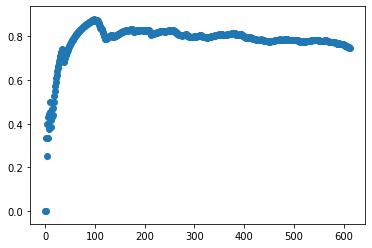

In [22]:
print(df_sim_results_01.shape)
print(min(df_sim_results_01['Datetime']))
print(max(df_sim_results_01['Datetime']))


print('% Model match: ', pp_model_match)

plt.scatter(range(0,len(ls_model_matches)), ls_model_matches)
plt.show()

# Simulation observations

In [23]:
df_sim_results_01['model_match'] = 0

df_sim_results_01.loc[
                (df_sim_results_01['target_order'].isin(['BUY','BUY2']))
                &(df_sim_results_01['prediction_order'].isin(['BUY','BUY2']))
                ,'model_match'] = 1
    
df_sim_results_01.loc[
                (df_sim_results_01['target_order'].isin(['SELL','SELL2']))
                &(df_sim_results_01['prediction_order'].isin(['SELL','SELL2']))
                 ,'model_match'] = 1


print(df_sim_results_01['model_match'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = False))


   index  model_match
0      1          458
1      0          155


In [24]:
df_sim_results_01['target_order_bin'] = 0
df_sim_results_01.loc[(df_sim_results_01['target_order'].isin(['BUY','BUY2'])) ,'target_order_bin'] = 1

print(df_sim_results_01['target_order_bin'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = False))


   index  target_order_bin
1      1               260
0      0               353


In [25]:
df_sim_results_01['date'] = df_sim_results_01['Datetime'].apply(lambda x: x.date())
df_sim_results_01['weekday'] = df_sim_results_01['Datetime'].apply(lambda x: x.weekday())
df_sim_results_01['time'] = df_sim_results_01['Datetime'].apply(lambda x: str(x.hour) + '-' + str(x.minute))

print(df_sim_results_01['weekday'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = False))


   index  weekday
1      4      150
0      3      150
2      2      149
3      1       99
4      0       65


In [26]:
df_datesumm = df_sim_results_01.groupby(['date']).agg(
    total_orders = ('Datetime','count'),
    total_buys = ('target_order_bin','sum'),
    total_matches = ('model_match','sum'),
    ).copy()

df_datesumm = df_datesumm.reset_index()

df_datesumm['pp_model_match'] = df_datesumm['total_matches'] / df_datesumm['total_orders']
df_datesumm['pp_buy'] = df_datesumm['total_buys'] / df_datesumm['total_orders']


df_datesumm

date  total_orders  total_buys  total_matches  pp_model_match  \
0   2022-02-16            49          35             37        0.755102   
1   2022-02-17            50           0             50        1.000000   
2   2022-02-18            50          21             34        0.680000   
3   2022-02-22            49          14             42        0.857143   
4   2022-02-23            50           6             42        0.840000   
5   2022-02-24            50          46             33        0.660000   
6   2022-02-25            50          20             43        0.860000   
7   2022-02-28            49          21             39        0.795918   
8   2022-03-01            50          24             29        0.580000   
9   2022-03-02            50          31             40        0.800000   
10  2022-03-03            50          16             40        0.800000   
11  2022-03-04            50          26             28        0.560000   
12  2022-03-07            16           0              1        0.062500   

      pp_buy  
0   0.714286  
1   0.000000  
2   0.420000  
3   0.285714  
4   0.120000  
5   0.920000  
6   0.400000  
7   0.428571  
8   0.480000  
9   0.620000  
10  0.320000  
11  0.520000  
12  0.000000

# Data observation

In [32]:
df_sim_results_02 = df_sim_results_01[df_sim_results_01['index']==0]
df_sim_results_02

index            Datetime        Close target_order  target_close  \
0        0 2022-02-16 09:45:00  4437.689941         BUY2   4471.569824   
2        0 2022-02-16 10:00:00  4439.830078         BUY2   4471.569824   
4        0 2022-02-16 10:15:00  4442.410156         BUY2   4471.569824   
6        0 2022-02-16 10:30:00  4443.709961         BUY2   4471.569824   
8        0 2022-02-16 10:45:00  4439.470215         BUY2   4471.569824   
..     ...                 ...          ...          ...           ...   
603      0 2022-03-07 10:30:00  4266.560059         NULL           NaN   
605      0 2022-03-07 10:45:00  4261.279785         NULL           NaN   
607      0 2022-03-07 11:00:00  4267.209961         NULL           NaN   
609      0 2022-03-07 11:15:00  4269.169922         NULL           NaN   
611      0 2022-03-07 11:30:00  4262.000000         NULL           NaN   

     target_difference         target_date  target_date_diff  \
0                 34.0 2022-02-16 14:15:00             270.0   
2                 32.0 2022-02-16 14:15:00             255.0   
4                 29.0 2022-02-16 14:15:00             240.0   
6                 28.0 2022-02-16 14:15:00             225.0   
8                 32.0 2022-02-16 14:15:00             210.0   
..                 ...                 ...               ...   
603                NaN                 NaT               NaN   
605                NaN                 NaT               NaN   
607                NaN                 NaT               NaN   
609                NaN                 NaT               NaN   
611                NaN                 NaT               NaN   

    target_order_coded y_pred  ...         1         2         3  max_prob  \
0                   01     03  ...  0.238808  0.149406  0.391786  0.391786   
2                   01     01  ...  0.529201  0.062876  0.397923  0.529201   
4                   01     01  ...  0.559323  0.049304  0.391373  0.559323   
6                   01     01  ...  0.549081  0.103402  0.327517  0.549081   
8                   01     01  ...  0.560000  0.050000  0.370000  0.560000   
..                 ...    ...  ...       ...       ...       ...       ...   
603                 02     00  ...  0.133120  0.213768  0.091438  0.561673   
605                 02     00  ...  0.140000  0.150357  0.100000  0.609643   
607                 02     00  ...  0.053047  0.160377  0.120803  0.665773   
609                 02     00  ...  0.071506  0.136524  0.095804  0.696165   
611                 02     00  ...  0.161322  0.140778  0.054898  0.643002   

     Model match  model_match  target_order_bin        date  weekday   time  
0       0.647059            0                 1  2022-02-16        2   9-45  
2       0.680000            1                 1  2022-02-16        2   10-0  
4       0.693878            1                 1  2022-02-16        2  10-15  
6       0.708333            1                 1  2022-02-16        2  10-30  
8       0.744681            1                 1  2022-02-16        2  10-45  
..           ...          ...               ...         ...      ...    ...  
603     0.000000            0                 0  2022-03-07        0  10-30  
605     0.000000            0                 0  2022-03-07        0  10-45  
607     0.000000            0                 0  2022-03-07        0   11-0  
609     0.000000            0                 0  2022-03-07        0  11-15  
611     0.000000            0                 0  2022-03-07        0  11-30  

[308 rows x 22 columns]

In [33]:
# Confusion Matrix

ls_model_matches = []

for i in range(1,len(df_sim_results_02)+1):
    #df_model_preds_01 = df_model_preds[df_model_preds['max_prob']>=0.42].copy()
    df_model_preds_01 = df_sim_results_02.iloc[:i,].copy()


    df_summary = df_model_preds_01.groupby(['target_order','prediction_order'] ).agg(
        orders_quantity = ('max_prob','count'),
        median_time = ('target_date_diff','median')
    )

    df_summary = df_summary.reset_index()

    True_buys = sum(df_summary[(df_summary['target_order'].isin(['BUY','BUY2']))&(df_summary['prediction_order'].isin(['BUY','BUY2']))]['orders_quantity'])
    True_sells = sum(df_summary[(df_summary['target_order'].isin(['SELL','SELL2']))&(df_summary['prediction_order'].isin(['SELL','SELL2']))]['orders_quantity'])
    Total_orders = sum(df_summary['orders_quantity'])

    pp_model_match = (True_buys + True_sells) / Total_orders
    ls_model_matches.append(pp_model_match)

print('% Model match: ', pp_model_match)
df_summary.sort_values(['orders_quantity'],ascending=[False])

% Model match:  0.8084415584415584


target_order prediction_order  orders_quantity  median_time
12         SELL             SELL               67         60.0
0           BUY              BUY               66         45.0
17        SELL2            SELL2               57       1155.0
5          BUY2             BUY2               17       1065.0
16        SELL2             SELL               16       1117.5
6          BUY2             SELL               10        150.0
2           BUY             SELL               10         75.0
1           BUY             BUY2                9         75.0
13         SELL            SELL2                9         60.0
14        SELL2              BUY                9       1170.0
4          BUY2              BUY                8        187.5
7          BUY2            SELL2                8        247.5
8          NULL              BUY                6          NaN
10         SELL              BUY                6         75.0
11         SELL             BUY2                4         45.0
3           BUY            SELL2                3         75.0
15        SELL2             BUY2                2       2722.5
9          NULL             SELL                1          NaN

In [34]:
df_datesumm = df_sim_results_02.groupby(['date']).agg(
    total_orders = ('Datetime','count'),
    total_buys = ('target_order_bin','sum'),
    total_matches = ('model_match','sum'),
    ).copy()

df_datesumm = df_datesumm.reset_index()

df_datesumm['pp_model_match'] = df_datesumm['total_matches'] / df_datesumm['total_orders']
df_datesumm['pp_buy'] = df_datesumm['total_buys'] / df_datesumm['total_orders']


df_datesumm

date  total_orders  total_buys  total_matches  pp_model_match  \
0   2022-02-16            25          18             21           0.840   
1   2022-02-17            25           0             25           1.000   
2   2022-02-18            25          10             20           0.800   
3   2022-02-22            25           7             22           0.880   
4   2022-02-23            25           3             22           0.880   
5   2022-02-24            25          23             20           0.800   
6   2022-02-25            25          10             21           0.840   
7   2022-02-28            25          11             21           0.840   
8   2022-03-01            25          12             17           0.680   
9   2022-03-02            25          16             21           0.840   
10  2022-03-03            25           8             22           0.880   
11  2022-03-04            25          13             16           0.640   
12  2022-03-07             8           0              1           0.125   

    pp_buy  
0     0.72  
1     0.00  
2     0.40  
3     0.28  
4     0.12  
5     0.92  
6     0.40  
7     0.44  
8     0.48  
9     0.64  
10    0.32  
11    0.52  
12    0.00